#Deep Learning : GATv2

# Introduction

Project 2: GNNs based sources integration
Project steps:
1. Preprocessing and reducing the dimension of the data using auto-encoders
2. Implementing GNNs (GATV2) in order to predict bladder cancer
3. Analyzing the results by varying the different hyperparameters using cross validation

Author : Clara Martinez, Emil, Fedor, Savelii Komlev, Oussama Haraja

**Date** : 01/12/2023

# Get data

In [ ]:
import gdown

We have reduced feature dimensions for all 4 datasets. And we saved them as .csv files in our shared Google drive. Here we pull them up.

In [ ]:
!gdown 1S4QLt4BNKVIUrduk2vwAwraWGLPm-M0m
!gdown 1-A7xnRBc4MTgFL5ieC9uJUaxYUbuFUfg -O prot_exp_art_embedding.csv
!gdown 1zxEwc3rZ41oMZzUsSxL0UrJlxhtLL1FV -O rna_exp_embedding_no_deseq.csv
!gdown 137LbQckWesV3qXDVRayMq-5fk4LMKFEH -O mirna_embedding.csv
!gdown 1S-ad4hPzFHuX8h5wf7LKPvE1FS4ukaRl -O meth_embedding.csv

Downloading...
From: https://drive.google.com/uc?id=1S4QLt4BNKVIUrduk2vwAwraWGLPm-M0m
To: /content/Projet_M2.zip
100% 152M/152M [00:00<00:00, 173MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-A7xnRBc4MTgFL5ieC9uJUaxYUbuFUfg
To: /content/prot_exp_art_embedding.csv
100% 98.1k/98.1k [00:00<00:00, 90.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zxEwc3rZ41oMZzUsSxL0UrJlxhtLL1FV
To: /content/rna_exp_embedding_no_deseq.csv
100% 113k/113k [00:00<00:00, 90.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=137LbQckWesV3qXDVRayMq-5fk4LMKFEH
To: /content/mirna_embedding.csv
100% 51.2k/51.2k [00:00<00:00, 82.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S-ad4hPzFHuX8h5wf7LKPvE1FS4ukaRl
To: /content/meth_embedding.csv
100% 113k/113k [00:00<00:00, 71.3MB/s]


In [ ]:
!unzip /content/Projet_M2.zip

Archive:  /content/Projet_M2.zip
replace Projet_GEN/labels_str.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data transformation



## Merge datasets

### Omics data

In [ ]:
import pandas as pd

Here read both versions of datasets. First 4 - the features that were given to us. We keep it for the demonstration purpose - we want to show how we reduced the dimensions. Second 4 datasets are the datasets that we are using to train and test our model.

In [ ]:
meth = pd.read_csv('/content/Projet_GEN/Omics/methylation_norm.csv', index_col=0)
gene_exp = pd.read_csv('/content/Projet_GEN/Omics/gene-expression_norm.csv', index_col=0)
mirna_exp = pd.read_csv('/content/Projet_GEN/Omics/mirna-expression_norm.csv', index_col=0)
prot_exp = pd.read_csv('/content/Projet_GEN/Omics/protein-expression_norm.csv', index_col=0)

prot_exp_artificial = pd.read_csv('/content/prot_exp_art_embedding.csv')
mirna_embedding = pd.read_csv('/content/mirna_embedding.csv')
rna_exp_embedding_no_deseq = pd.read_csv('/content/rna_exp_embedding_no_deseq.csv')
meth_embedding = pd.read_csv('/content/meth_embedding.csv')

In [ ]:
prot_exp_artificial = prot_exp_artificial.set_index(["Unnamed: 0"])
mirna_embedding = mirna_embedding.set_index(["Unnamed: 0"])
rna_exp_embedding_no_deseq = rna_exp_embedding_no_deseq.set_index(["Unnamed: 0"])
meth_embedding = meth_embedding.set_index(["Unnamed: 0"])

prot_exp_artificial = prot_exp_artificial.drop(columns=["class"])
prot_exp_artificial = prot_exp_artificial.apply(pd.to_numeric)

mirna_embedding = mirna_embedding.drop(columns=["class"])
mirna_embedding = mirna_embedding.apply(pd.to_numeric)

rna_exp_embedding_no_deseq = rna_exp_embedding_no_deseq.drop(columns=["class"])
rna_exp_embedding_no_deseq = rna_exp_embedding_no_deseq.apply(pd.to_numeric)

meth_embedding = meth_embedding.drop(columns=["class"])
meth_embedding = meth_embedding.apply(pd.to_numeric)

In [ ]:
print(meth.columns)
print(gene_exp.columns)
print(mirna_exp.columns)
print(prot_exp.columns)

Index(['RBL2', 'VDAC3', 'ACTN1', 'ATP2A1', 'SFRP1', 'NIPA2', 'MAN1B1',
       'TSEN34', 'LRRC16A', 'CNBP',
       ...
       'BAGE5', 'BAGE', 'BAGE2', 'BAGE4', 'BAGE3', 'MIR637', 'LOC100130932',
       'GOLGA8F', 'GOLGA8G', 'MIR7-1'],
      dtype='object', length=20109)
Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'SNORA74C-2', 'ELOA3BP', 'NPBWR1', 'ELOA3DP', 'PDCD6-AHRR', 'ELOA3P',
       'LNCDAT', 'CDR1', 'ACTL10', 'PANO1'],
      dtype='object', length=40281)
Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-941-5', 'hsa-mir-942', 'hsa-mir-943', 'hsa-mir-944',
       'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a',
       'hsa-mir-99b'],
      dtype='object', length=1881)
Index(['YWHAB', 'YWHAE', 'YWHAZ', 'EIF4EBP1', 'TP53BP1', 'ACACA, B', 'A

In [ ]:
print(meth.shape)
print(gene_exp.shape)
print(mirna_exp.shape)
print(prot_exp.shape)

(412, 20109)
(406, 40281)
(409, 1881)
(343, 348)


### Clinical data

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
tumor_event = pd.read_csv('/content/Projet_GEN/Clinical/new-tumor-event_norm.csv', index_col=0)

In [ ]:
patient_info = pd.read_csv('/content/Projet_GEN/Clinical/patient-info_norm.csv', index_col=0)

In [ ]:
clin_df = pd.merge(tumor_event, patient_info, on = "patient", how='outer')
clin_df.head()

,days_to_new_tumor_event_after_initial_treatment,Liver,Bone,Adrenal,Lymph nodes,Lung,Rectum,Pelvis,Bladder,Brain,...,ASIAN,Manual,Office,Health,Teacher,Military,Retired,Transport,Homemaker,Chimique
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KO,0.132668,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-2F-A9KP,0.069900,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
TCGA-2F-A9KR,0.628897,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TCGA-2F-A9KW,0.017322,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TCGA-4Z-AA7R,0.071938,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(set(tumor_event.index) | set(patient_info.index))

412

In [ ]:
clin_df.isnull().sum(axis = 0)

days_to_new_tumor_event_after_initial_treatment    281
Liver                                              281
Bone                                               281
Adrenal                                            281
Lymph nodes                                        281
Lung                                               281
Rectum                                             281
Pelvis                                             281
Bladder                                            281
Brain                                              281
Soft Tissue                                        281
Colon                                              281
Abdominal wall                                     281
Other                                              281
Urethra                                            281
Genital Tool                                       281
Distant Metastasis                                 281
Locoregional (Urothelial tumor event)              281
New Primar

In [ ]:
clin_df = clin_df.fillna(0)

### Labels

In [ ]:
labels = pd.read_csv('/content/Projet_GEN/labels_str.csv', index_col=0)
labels_onehot = pd.read_csv('/content/Projet_GEN/labels_onehot.csv', index_col=0)

In [ ]:
labels_onehot.shape

(406, 6)

In [ ]:
labels = pd.read_csv('/content/Projet_GEN/labels_str.csv', index_col=0)
labels_onehot = pd.read_csv('/content/Projet_GEN/labels_onehot.csv', index_col=0)

In [ ]:
labels_onehot.head()

,LumP,Ba/Sq,LumU,Stroma-rich,LumNS,NE-like
ID,,,,,,
TCGA-2F-A9KO,1,0,0,0,0,0
TCGA-2F-A9KP,1,0,0,0,0,0
TCGA-2F-A9KQ,1,0,0,0,0,0
TCGA-2F-A9KR,0,1,0,0,0,0
TCGA-2F-A9KT,0,1,0,0,0,0


In [ ]:
labels.head()

,class
ID,
TCGA-2F-A9KO,LumP
TCGA-2F-A9KP,LumP
TCGA-2F-A9KQ,LumP
TCGA-2F-A9KR,Ba/Sq
TCGA-2F-A9KT,Ba/Sq


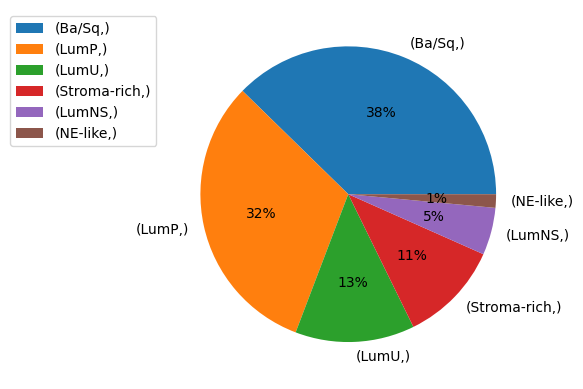

In [ ]:
labels.value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.legend(bbox_to_anchor=(0,1))

In [ ]:
labels.value_counts()

class      
Ba/Sq          153
LumP           128
LumU            53
Stroma-rich     45
LumNS           21
NE-like          6
dtype: int64

In [ ]:
labels.isna().sum()

class    0
dtype: int64

# Autoencoders

## Functions

In [ ]:
from sklearn.model_selection import train_test_split
import scipy.stats as sps
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

def scale_datasets(x_train, x_test):
  """
  MinMax Scale test and train data
  """
  scaler = MinMaxScaler()
  x_train_scaled = pd.DataFrame(
      scaler.fit_transform(x_train),
      columns=x_train.columns,
      index=x_train.index
  )
  x_test_scaled = pd.DataFrame(
      scaler.transform(x_test),
      columns = x_test.columns,
      index=x_test.index
  )
  return x_train_scaled, x_test_scaled

def merge_split_scale_pipeline(X, labels, TARGET_NAME = 'class'):
  """
  Generates train and test data from the omics DataFrame with the provided target labels. Omics data is being scaled to achieve consistency
  """
  X_label = pd.merge(X, labels, left_index=True, right_index=True)
  X_label = X_label[X_label[TARGET_NAME].notna()]
  train_data, test_data = train_test_split(X_label, test_size=0.2, random_state=42)

  x_train, y_train = train_data.drop([TARGET_NAME], axis=1), train_data[TARGET_NAME]
  x_test, y_test = test_data.drop([TARGET_NAME], axis=1), test_data[TARGET_NAME]
  x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)
  return x_train_scaled, x_test_scaled, y_train, y_test

In [ ]:
def reduce_dim(omics, auto_encoder):
    omics_scaled =  MinMaxScaler().fit_transform(omics)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder_layer = auto_encoder.encoder.to(device)
    omics_scaled_tensor = torch.tensor(omics_scaled, dtype=torch.float32)

    auto_encoder.eval()
    with torch.no_grad():
        encoded_tensor = encoder_layer(omics_scaled_tensor.to(device))

    reduced_df = pd.DataFrame(encoded_tensor.cpu().numpy(), columns=[f'feature_{i}' for i in range(encoded_tensor.shape[1])])
    reduced_df.index = omics.index

    return reduced_df

In [ ]:
def encoded_stats(df):
    X = df.drop('class', axis=1)
    y = df['class']

    # Encode the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)

    # Initialize and train the XGBoost classifier with 'f1' as the evaluation metric
    xgb_classifier = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Evaluate the model using F1-score
    f1 = f1_score(le.inverse_transform(y_test), le.inverse_transform(y_pred), average='weighted')
    print(f"F1-score: {f1:.2f}")

    # Print classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

    print("\nConfusion Matrix:")
    print(confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

### Protein

This is the only omics modality that needs to be especially tackled, as 15% of the samples lack the data. We fill the nans with median values to deal with it

In [ ]:
prot_exp_labeled = pd.merge(prot_exp, labels, left_index=True, right_index=True, how='outer')

In [ ]:
absent_pats = pd.Index(list(set(labels.index) - set(prot_exp.index)))
labels.loc[absent_pats].value_counts()

class      
LumP           27
Ba/Sq          19
LumU           11
Stroma-rich     9
LumNS           2
NE-like         1
dtype: int64

In [ ]:
# import scipy.stats as sps
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# artificial_prot = pd.DataFrame([], columns=prot_exp.columns)
# for cl in np.unique(labels):
#     slice = prot_exp_labeled[prot_exp_labeled['class'] == cl].drop(columns='class')
#     slice = slice.fillna(slice.median()) + sps.norm.rvs(loc=0, scale=0.05, size=slice.shape, random_state=None)
#     sclr = MinMaxScaler()
#     slice_transformed = sclr.fit_transform(slice)
#     slice_transformed = pd.DataFrame(data=slice_transformed, columns=slice.columns, index=slice.index)

#     artificial_prot = pd.concat((artificial_prot, slice_transformed))

In [ ]:
artificial_prot = prot_exp_labeled.fillna(prot_exp_labeled.median()).drop(columns=['class'])
artificial_prot.shape

<ipython-input-31-a6bb2fa3549c>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  artificial_prot = prot_exp_labeled.fillna(prot_exp_labeled.median()).drop(columns=['class'])


(412, 348)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

class AutoEncoder(nn.Module):
    def __init__(self, input_size, reduced_size, dropout_prob=.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(32, reduced_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(reduced_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 50, verbose=True):
  input_size = len(x_train_scaled.columns)
  auto_encoder = AutoEncoder(input_size, reduced_size)

  train_losses = list()
  val_losses = list()

  # Training loop
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  auto_encoder.to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(auto_encoder.parameters(), lr=0.0005)
  # scheduler = ExponentialLR(optimizer, gamma=0.9)

  # Convert data to PyTorch tensors
  x_train_tensor = torch.tensor(x_train_scaled.values, dtype=torch.float32).to(device)
  x_test_tensor = torch.tensor(x_test_scaled.values, dtype=torch.float32).to(device)

  train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

  # Training loop
  for epoch in range(num_epochs):
      for data in train_loader:
          inputs, targets = data
          inputs, targets = inputs.to(device), targets.to(device)
          optimizer.zero_grad()
          outputs = auto_encoder(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
      # scheduler.step()

      with torch.no_grad():
          x_test_tensor = x_test_tensor.to(device)
          outputs = auto_encoder(x_test_tensor)
          val_loss = criterion(outputs, x_test_tensor)


      val_losses.append(val_loss.cpu().numpy())
      train_losses.append(loss.item())
      if verbose:
          print(f'Epoch {epoch},\tTrain Loss: {loss.item():.4f} \t Val Loss: {val_loss.item():.4f}')

  return auto_encoder, val_losses, train_losses

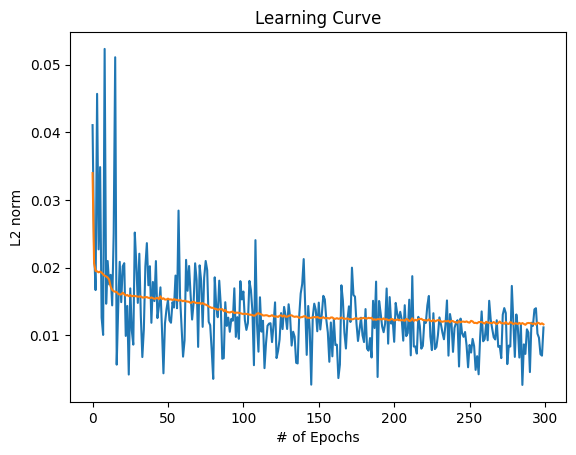

In [ ]:
x_train_scaled, x_test_scaled, y_train, y_test = merge_split_scale_pipeline(artificial_prot, labels)

reduced_size = 20
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 300, verbose=False)

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('# of Epochs')
plt.ylabel('L2 norm')
plt.title('Learning Curve')
plt.show()

100%|██████████| 20/20 [04:16<00:00, 12.82s/it]


Text(0.5, 1.0, 'Train')

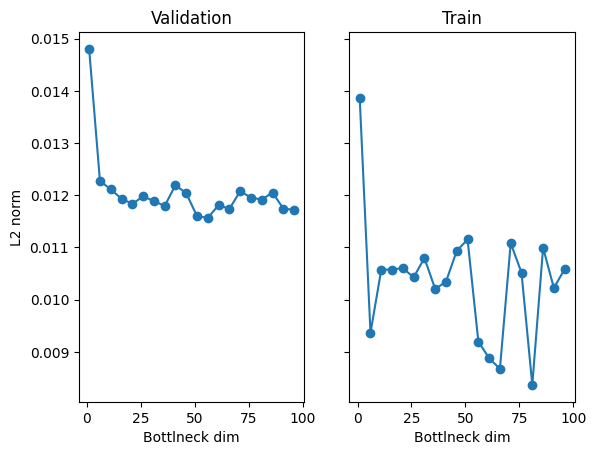

In [ ]:
import numpy as np
from tqdm import tqdm

dims = np.arange(1, 100, 5)

val_losses = []
train_losses = []
for dim in tqdm(dims):
    auto_encoder, val_loss, train_loss = training_loop(dim, x_train_scaled, x_test_scaled, num_epochs=250, verbose=False)
    val_losses.append(np.array(val_loss[-10:]).mean())
    train_losses.append(np.array(train_loss[-10:]).mean())

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(dims, val_losses, '-o')
ax[0].set_xlabel('Bottlneck dim')
ax[0].set_ylabel('L2 norm')
ax[0].set_title('Validation')

ax[1].plot(dims, train_losses, '-o')
ax[1].set_xlabel('Bottlneck dim')
ax[1].set_title('Train')

Elbow method: we take 21 as a bottleneck dimension

Checking out the stats of GB model on encoded data:

In [ ]:
reduced_size = 21
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 300, verbose=False)

omics = artificial_prot

reduced_df = reduce_dim(omics, auto_encoder)

omics_label = pd.merge(omics, labels, left_index=True, right_index=True)
reduced_df['class'] = omics_label['class']
df = reduced_df[~reduced_df['class'].isna()]

encoded_stats(df)

F1-score: 0.54

Classification Report:
              precision    recall  f1-score   support

       Ba/Sq       0.70      0.76      0.73        25
       LumNS       0.00      0.00      0.00         4
        LumP       0.67      0.57      0.62        21
        LumU       0.14      0.20      0.17         5
 Stroma-rich       0.20      0.17      0.18         6

    accuracy                           0.54        61
   macro avg       0.34      0.34      0.34        61
weighted avg       0.55      0.54      0.54        61


Confusion Matrix:
[[19  0  4  1  1]
 [ 2  0  0  0  2]
 [ 1  2 12  5  1]
 [ 2  0  2  1  0]
 [ 3  2  0  0  1]]


## Autoencoder for normalised RNA-seq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

# class AutoEncoderRNA(nn.Module):
#     def __init__(self, input_size, reduced_size, dropout_prob=.7):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(input_size, 128),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(32, reduced_size)
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(reduced_size, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, input_size),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

import torch.nn as nn

class AutoEncoderRNA(nn.Module):
    def __init__(self, input_size, reduced_size, dropout_prob=0.7):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(32, reduced_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(reduced_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def training_loopRNA(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 50, verbose=True):
  input_size = len(x_train_scaled.columns)
  auto_encoder = AutoEncoderRNA(input_size, reduced_size)

  # Training loop
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  auto_encoder.to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(auto_encoder.parameters(), lr=0.0005)
  # scheduler = ExponentialLR(optimizer, gamma=0.90)

  # Convert data to PyTorch tensors
  x_train_tensor = torch.tensor(x_train_scaled.values, dtype=torch.float32).to(device)
  x_test_tensor = torch.tensor(x_test_scaled.values, dtype=torch.float32).to(device)

  train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

  train_losses = list()
  val_losses = list()

  # Training loop
  for epoch in range(num_epochs):
      for data in train_loader:
          inputs, targets = data
          inputs, targets = inputs.to(device), targets.to(device)
          optimizer.zero_grad()
          outputs = auto_encoder(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
      # scheduler.step()

      with torch.no_grad():
          x_test_tensor = x_test_tensor.to(device)
          outputs = auto_encoder(x_test_tensor)
          val_loss = criterion(outputs, x_test_tensor)


      val_losses.append(val_loss.cpu())
      train_losses.append(loss.item())
      if verbose:
          print(f'Epoch {epoch},\tTrain Loss: {loss.item():.4f} \t Val Loss: {val_loss.item():.4f}')

  # Validation
  with torch.no_grad():
      x_test_tensor = x_test_tensor.to(device)
      outputs = auto_encoder(x_test_tensor)
      val_loss = criterion(outputs, x_test_tensor)
  if verbose:
      print(f'Validation Loss: {val_loss.item()}')

  return auto_encoder, val_losses, train_losses

RNAseq data has much more plexity, so 3 hundreds samples are not enough for the model to catch the structure of the data and generalise. In order to tackle it we proceed with the filtering process, leaving only the protein coding genes These were extracted via Ensembl BiomaRt using the following R script:
``` R
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install("biomaRt")

mart <- useEnsembl("ensembl","hsapiens_gene_ensembl")
results <- getBM(attributes=c("hgnc_symbol","transcript_biotype"),
            filters = c("transcript_biotype"), values=list("protein_coding"),
            mart=mart)
```

Also we filter the transcriptome by leaving the genes that arabsent in more than 250 patients

(array([18412.,  1521.,  1323.,  1183.,  1209.,  1266.,  1487.,  1654.,
         2785.,  9441.]),
 array([  1. ,  41.5,  82. , 122.5, 163. , 203.5, 244. , 284.5, 325. ,
        365.5, 406. ]),
 <BarContainer object of 10 artists>)

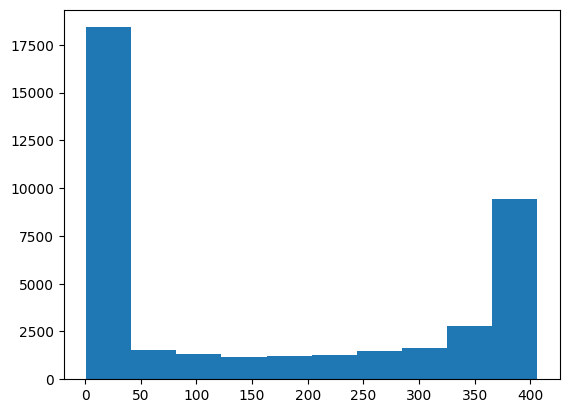

In [ ]:
plt.hist((gene_exp == 0).sum(axis=0))

In [ ]:
filtered_genes = (gene_exp == 0).sum(axis=0) < 250
coding_genes = set(pd.read_csv('coding_genes.csv', index_col=0).index) & set(filtered_genes.index)
filtered_genes = filtered_genes.loc[coding_genes]
filtered_genes = filtered_genes.loc[filtered_genes].index

print(f'{gene_exp.shape[1]}\tGenes before filtering')
print(f'{len(filtered_genes)}\tGenes before filtering')

40281	Genes before filtering
17327	Genes before filtering


<ipython-input-39-37908ab9f469>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filtered_genes = filtered_genes.loc[coding_genes]


In [ ]:
gene_exp_filtered = gene_exp.loc[:,filtered_genes]

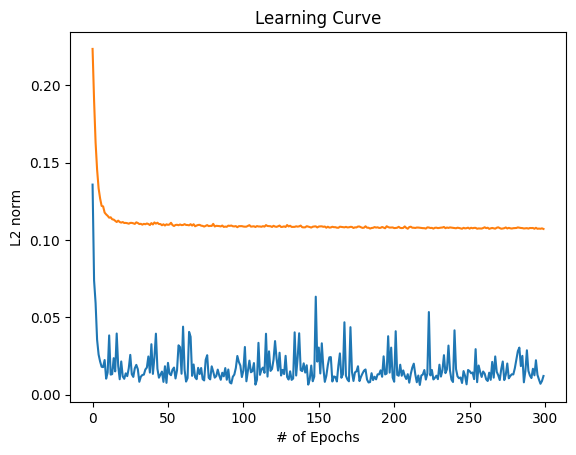

In [ ]:
x_train_scaled, x_test_scaled, y_train, y_test = merge_split_scale_pipeline(gene_exp_filtered, labels)

reduced_size = 20
auto_encoder, val_loss, train_loss = training_loopRNA(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 300, verbose=False)

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('# of Epochs')
plt.ylabel('L2 norm')
plt.title('Learning Curve')
plt.show()

100%|██████████| 10/10 [03:18<00:00, 19.80s/it]


Text(0.5, 1.0, 'Train')

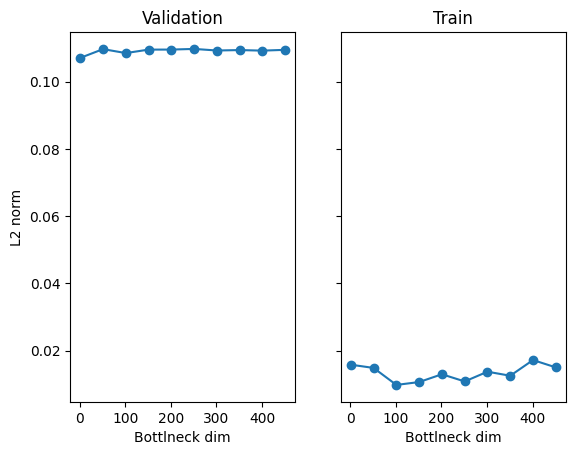

In [ ]:
import numpy as np
from tqdm import tqdm

dims = np.arange(1, 500, 50)

val_losses = []
train_losses = []
for dim in tqdm(dims):
    auto_encoder, val_loss, train_loss = training_loop(dim, x_train_scaled, x_test_scaled, num_epochs=30, verbose=False)
    val_losses.append(np.array(val_loss[-10:]).mean())
    train_losses.append(np.array(train_loss[-10:]).mean())

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(dims, val_losses, '-o')
ax[0].set_xlabel('Bottlneck dim')
ax[0].set_ylabel('L2 norm')
ax[0].set_title('Validation')

ax[1].plot(dims, train_losses, '-o')
ax[1].set_xlabel('Bottlneck dim')
ax[1].set_title('Train')

In [ ]:
reduced_size = 21
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 150, verbose=False)

omics = gene_exp_filtered

reduced_df = reduce_dim(omics, auto_encoder)

omics_label = pd.merge(omics, labels, left_index=True, right_index=True)
reduced_df['class'] = omics_label['class']
df = reduced_df[~reduced_df['class'].isna()]

encoded_stats(df)

F1-score: 0.66

Classification Report:
              precision    recall  f1-score   support

       Ba/Sq       0.80      0.83      0.81        29
       LumNS       0.00      0.00      0.00         3
        LumP       0.62      0.81      0.70        16
        LumU       0.50      0.29      0.36         7
     NE-like       0.00      0.00      0.00         1
 Stroma-rich       0.60      0.60      0.60         5

    accuracy                           0.69        61
   macro avg       0.42      0.42      0.41        61
weighted avg       0.65      0.69      0.66        61


Confusion Matrix:
[[24  0  4  0  0  1]
 [ 0  0  2  1  0  0]
 [ 1  1 13  1  0  0]
 [ 2  0  2  2  0  1]
 [ 1  0  0  0  0  0]
 [ 2  0  0  0  0  3]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## miRNA

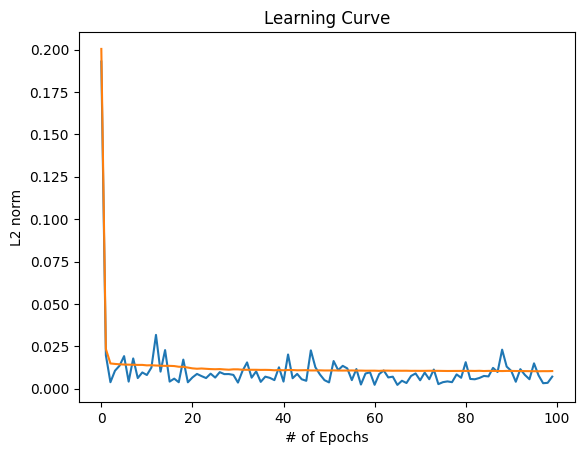

In [ ]:
x_train_scaled, x_test_scaled, y_train, y_test = merge_split_scale_pipeline(mirna_exp, labels)

reduced_size = 20
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 100, verbose=False)

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('# of Epochs')
plt.ylabel('L2 norm')
plt.title('Learning Curve')
plt.show()

100%|██████████| 20/20 [03:58<00:00, 11.95s/it]


Text(0.5, 1.0, 'Train')

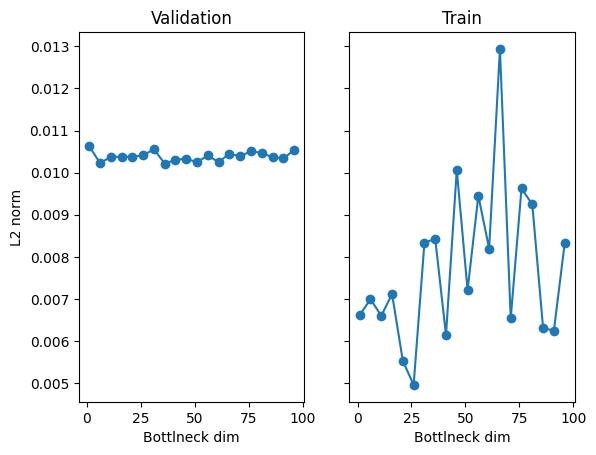

In [ ]:
import numpy as np
from tqdm import tqdm

dims = np.arange(1, 100, 5)

val_losses = []
train_losses = []
for dim in tqdm(dims):
    auto_encoder, val_loss, train_loss = training_loop(dim, x_train_scaled, x_test_scaled, num_epochs=100, verbose=False)
    val_losses.append(np.array(val_loss[-10:]).mean())
    train_losses.append(np.array(train_loss[-10:]).mean())

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(dims, val_losses, '-o')
ax[0].set_xlabel('Bottlneck dim')
ax[0].set_ylabel('L2 norm')
ax[0].set_title('Validation')

ax[1].plot(dims, train_losses, '-o')
ax[1].set_xlabel('Bottlneck dim')
ax[1].set_title('Train')

In [ ]:
reduced_size = 21
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 100, verbose=False)

omics = mirna_exp

reduced_df = reduce_dim(omics, auto_encoder)

omics_label = pd.merge(omics, labels, left_index=True, right_index=True)
reduced_df['class'] = omics_label['class']
df = reduced_df[~reduced_df['class'].isna()]

encoded_stats(df)

F1-score: 0.63

Classification Report:
              precision    recall  f1-score   support

       Ba/Sq       0.72      0.85      0.78        27
        LumP       0.79      0.68      0.73        22
        LumU       0.33      0.11      0.17         9
     NE-like       0.00      0.00      0.00         0
 Stroma-rich       0.00      0.00      0.00         3

    accuracy                           0.64        61
   macro avg       0.37      0.33      0.34        61
weighted avg       0.65      0.64      0.63        61


Confusion Matrix:
[[23  3  0  0  1]
 [ 3 15  2  0  2]
 [ 3  1  1  1  3]
 [ 0  0  0  0  0]
 [ 3  0  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Methylation

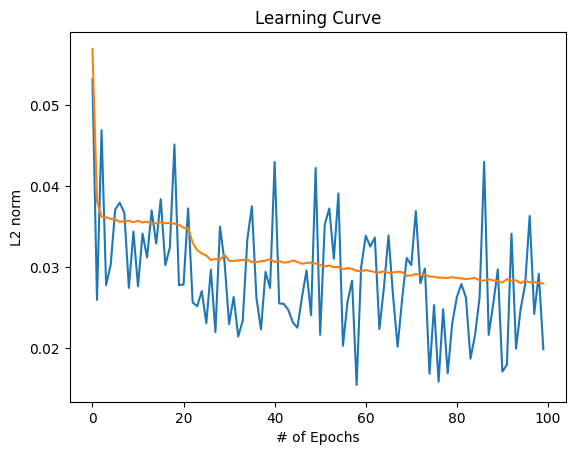

In [ ]:
x_train_scaled, x_test_scaled, y_train, y_test = merge_split_scale_pipeline(meth, labels)

reduced_size = 20
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 300, verbose=False)

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('# of Epochs')
plt.ylabel('L2 norm')
plt.title('Learning Curve')
plt.show()

100%|██████████| 10/10 [26:12<00:00, 157.30s/it]


Text(0.5, 1.0, 'Train')

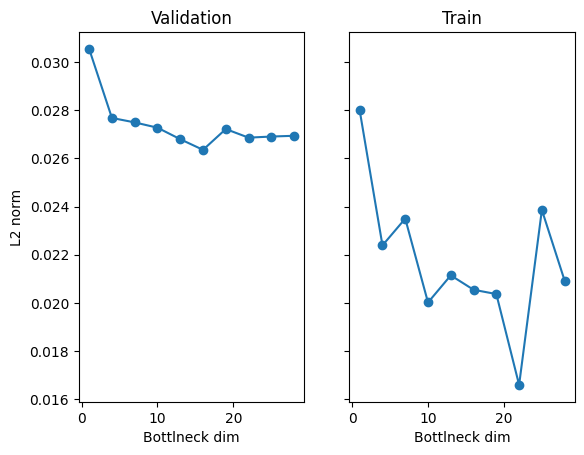

In [ ]:
dims = np.arange(1, 30, 3)

val_losses = []
train_losses = []
for dim in tqdm(dims):
    auto_encoder, val_loss, train_loss = training_loop(dim, x_train_scaled, x_test_scaled, num_epochs=200, verbose=False)
    val_losses.append(np.array(val_loss[-10:]).mean())
    train_losses.append(np.array(train_loss[-10:]).mean())

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(dims, val_losses, '-o')
ax[0].set_xlabel('Bottlneck dim')
ax[0].set_ylabel('L2 norm')
ax[0].set_title('Validation')

ax[1].plot(dims, train_losses, '-o')
ax[1].set_xlabel('Bottlneck dim')
ax[1].set_title('Train')

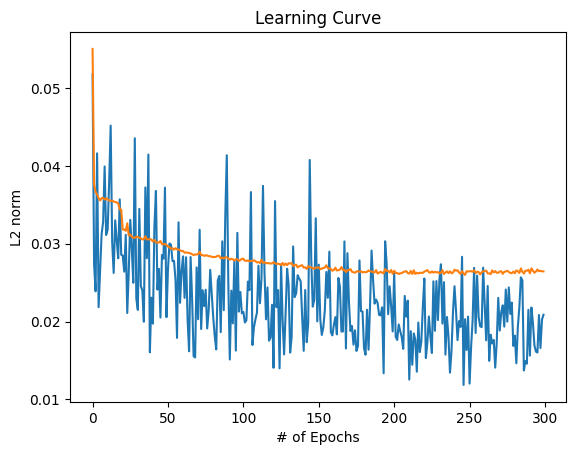

F1-score: 0.60

Classification Report:
              precision    recall  f1-score   support

       Ba/Sq       0.79      0.60      0.68        25
       LumNS       0.00      0.00      0.00         4
        LumP       0.75      0.71      0.73        21
        LumU       0.33      0.80      0.47         5
     NE-like       0.00      0.00      0.00         0
 Stroma-rich       0.29      0.33      0.31         6

    accuracy                           0.59        61
   macro avg       0.36      0.41      0.37        61
weighted avg       0.64      0.59      0.60        61


Confusion Matrix:
[[15  1  1  3  1  4]
 [ 0  0  3  1  0  0]
 [ 3  1 15  1  0  1]
 [ 0  0  1  4  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  3  0  2]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
reduced_size = 21
auto_encoder, val_loss, train_loss = training_loop(reduced_size, x_train_scaled, x_test_scaled, num_epochs = 300, verbose=False)

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('# of Epochs')
plt.ylabel('L2 norm')
plt.title('Learning Curve')
plt.show()

omics = meth

reduced_df = reduce_dim(omics, auto_encoder)

omics_label = pd.merge(omics, labels, left_index=True, right_index=True)
reduced_df['class'] = omics_label['class']
df = reduced_df[~reduced_df['class'].isna()]

encoded_stats(df)

#DESeq

In this part we are going to use DESeq2 to perform differental expression analysis on gene expression data. This will help give more interpretability to our data. We are going to reduce the numbre of genes into genes that are statisticaly significantly differentially expressed between the subtypes.

##DESeq2 data preprocessing(gene exp)



In [ ]:
gene_exp

In [ ]:
lables['ID']

In [ ]:
all(gene_exp['ID']==lables['ID'])# check if the gene expression data have all the samples from the lables

In [ ]:
lables_gene= lables[lables['ID'].isin(gene_exp['ID'])]#filter only the lables that exist in our gene expression data

In [ ]:
lables_gene

In [ ]:
merged_df = pd.merge(lables, gene_exp, on='ID', how='inner')#this step will help put the lables and the expression data in the same order based on the ID

In [ ]:
genex=merged_df.drop('class', axis=1)

since DESeq2 doesn't take counts in the table as floats we are forced to change the values into 'int' if we do it direclty without multiplying by 1000000 we will have a table with all the counts as 0
since the data is normalized multiplying all the values will not influence their degree of expression and they will still be normalized after

In [ ]:
genex.set_index('ID', inplace=True)
genex1=genex*1000000
genex1

here we will filter the counts that have an expression value for a gene
if a gene presents no expression for all the samples it will be excluded
having 0 expression in all samples means its irrelevent to this analysis

In [ ]:
column_sums = genex1.sum(axis=0)

# Filter columns based on the sum condition (sum > 0)
selected_columns = column_sums[column_sums > 0].index

# Use the selected_columns to filter the DataFrame
genex_filtered = genex1[selected_columns]

In [ ]:
genex_filtered = genex_filtered.astype(int)
genex_filtered

In [ ]:
print(genex_filtered.columns)

In [ ]:
lables_gene.set_index('ID', inplace=True)
lables_gene

##DESeq2(gene exp)

In [ ]:
%pip install pydeseq2

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
genex_filtered = genex_filtered.astype(int)
genex_filtered

In [ ]:
dds = DeseqDataSet(counts=genex_filtered, metadata=lables_gene, design_factors="class") #creat a DESeq2 object

In [ ]:
dds.deseq2()#applying DESeq2 on the object that will adapt to the data and compare between the samples abased on the factors of "class"

In [ ]:
dds#the object now contains all pairwise comparisons between the classes and statistics on each comparison

In [ ]:
stats=DeseqStats(dds)#extract the stats

In [ ]:
stats.summary()#this will give as an output a random comparison of all the comparisons since we run DeseqStats on the whole dds object to choose which one to give as an output we must specify the classes(commads below)

In [ ]:
np.unique(lables_gene['class'])

**extract stats for each pairwise comparison**

In [ ]:
stat_res_LumP_vs_BaSq = DeseqStats(dds, contrast = ('class','LumP','Ba/Sq'))
stat_res_LumP_vs_LumNS = DeseqStats(dds, contrast = ('class','LumP','LumNS'))
stat_res_LumP_vs_LumU = DeseqStats(dds, contrast = ('class','LumP','LumU'))
stat_res_LumP_vs_NE = DeseqStats(dds, contrast = ('class','LumP','NE-like'))
stat_res_LumP_vs_Stroma = DeseqStats(dds, contrast = ('class','LumP','Stroma-rich'))
stat_res_LumNS_vs_BaSq = DeseqStats(dds, contrast = ('class','LumNS','Ba/Sq'))
stat_res_LumNS_vs_LumU = DeseqStats(dds, contrast = ('class','LumNS','LumU'))
stat_res_LumNS_vs_NE = DeseqStats(dds, contrast = ('class','LumNS','NE-like'))
stat_res_LumNS_vs_Stroma = DeseqStats(dds, contrast = ('class','LumNS','Stroma-rich'))
stat_res_LumU_vs_BaSq = DeseqStats(dds, contrast = ('class','LumNS','Ba/Sq'))
stat_res_LumU_vs_NE = DeseqStats(dds, contrast = ('class','LumNS','NE-like'))
stat_res_LumU_vs_Stroma = DeseqStats(dds, contrast = ('class','LumNS','Stroma-rich'))
stat_res_BaSq_vs_NE = DeseqStats(dds, contrast = ('class','Ba/Sq','NE-like'))
stat_res_BaSq_vs_Stroma = DeseqStats(dds, contrast = ('class','Ba/Sq','Stroma-rich'))
stat_res_NE_vs_Stroma = DeseqStats(dds, contrast = ('class','NE-like','Stroma-rich'))

In [ ]:
stat_res_LumP_vs_BaSq.summary()
stat_res_LumP_vs_LumNS.summary()
stat_res_LumP_vs_LumU.summary()
stat_res_LumP_vs_NE.summary()
stat_res_LumP_vs_Stroma.summary()
stat_res_LumNS_vs_BaSq.summary()
stat_res_LumNS_vs_LumU.summary()
stat_res_LumNS_vs_NE.summary()
stat_res_LumNS_vs_Stroma.summary()
stat_res_LumU_vs_BaSq.summary()
stat_res_LumU_vs_NE.summary()
stat_res_LumU_vs_Stroma.summary()
stat_res_BaSq_vs_NE.summary()
stat_res_BaSq_vs_Stroma.summary()
stat_res_NE_vs_Stroma.summary()

**transform the stats tables into dataframes that will enable us to filter the genes based on significant statistical values**

In [ ]:
res_LumP_vs_BaSq=stat_res_LumP_vs_BaSq.results_df
res_LumP_vs_LumNS = stat_res_LumP_vs_LumNS.results_df
res_LumP_vs_LumU = stat_res_LumP_vs_LumU.results_df
res_LumP_vs_NE=stat_res_LumP_vs_NE.results_df
res_LumP_vs_Stroma=stat_res_LumP_vs_Stroma.results_df
res_LumNS_vs_BaSq = stat_res_LumNS_vs_BaSq.results_df
res_LumNS_vs_LumU = stat_res_LumNS_vs_LumU.results_df
res_LumNS_vs_NE = stat_res_LumNS_vs_NE.results_df
res_LumNS_vs_Stroma = stat_res_LumNS_vs_Stroma.results_df
res_LumU_vs_BaSq = stat_res_LumU_vs_BaSq.results_df
res_LumU_vs_NE = stat_res_LumU_vs_NE.results_df
res_LumU_vs_Stroma = stat_res_LumU_vs_Stroma.results_df
res_BaSq_vs_NE = stat_res_BaSq_vs_NE.results_df
res_BaSq_vs_Stroma = stat_res_BaSq_vs_Stroma.results_df
res_NE_vs_Stroma = stat_res_NE_vs_Stroma.results_df

**we choosed to filter based on the two most important statistical values: adjusted P-values and the Log2(FoldChange)**


we took 0.01 as a threshold for the adj-P and absolut log2(FC) > 10

In [ ]:
diff_exp_genes_LumP_vs_BaSq = res_LumP_vs_BaSq[(res_LumP_vs_BaSq.padj < 0.01) & (abs(res_LumP_vs_BaSq.log2FoldChange) > 10)]
diff_exp_genes_LumP_vs_LumNS = res_LumP_vs_LumNS[(res_LumP_vs_LumNS.padj < 0.01) & (abs(res_LumP_vs_LumNS.log2FoldChange) > 10)]
diff_exp_genes_LumP_vs_LumU = res_LumP_vs_BaSq[(res_LumP_vs_LumU.padj < 0.01) & (abs(res_LumP_vs_LumU.log2FoldChange) > 10)]
diff_exp_genes_LumP_vs_NE = res_LumP_vs_BaSq[(res_LumP_vs_NE.padj < 0.01) & (abs(res_LumP_vs_NE.log2FoldChange) > 10)]
diff_exp_genes_LumP_vs_Stroma = res_LumP_vs_Stroma[(res_LumP_vs_Stroma.padj < 0.01) & (abs(res_LumP_vs_Stroma.log2FoldChange) > 10)]
diff_exp_genes_LumNS_vs_BaSq = res_LumNS_vs_BaSq[(res_LumNS_vs_BaSq.padj < 0.01) & (abs(res_LumNS_vs_BaSq.log2FoldChange) > 10)]
diff_exp_genes_LumNS_vs_LumU = res_LumNS_vs_LumU[(res_LumNS_vs_LumU.padj < 0.01) & (abs(res_LumNS_vs_LumU.log2FoldChange) > 10)]
diff_exp_genes_LumNS_vs_NE = res_LumNS_vs_NE[(res_LumNS_vs_NE.padj < 0.01) & (abs(res_LumNS_vs_NE.log2FoldChange) > 10)]
diff_exp_genes_LumNS_vs_Stroma = res_LumNS_vs_Stroma[(res_LumNS_vs_Stroma.padj < 0.01) & (abs(res_LumNS_vs_Stroma.log2FoldChange) > 10)]
diff_exp_genes_LumU_vs_BaSq = res_LumU_vs_BaSq[(res_LumU_vs_BaSq.padj < 0.01) & (abs(res_LumU_vs_BaSq.log2FoldChange) > 10)]
diff_exp_genes_LumU_vs_NE = res_LumU_vs_NE[(res_LumU_vs_NE.padj < 0.01) & (abs(res_LumU_vs_NE.log2FoldChange) > 10)]
diff_exp_genes_LumU_vs_Stroma = res_LumU_vs_Stroma[(res_LumU_vs_Stroma.padj < 0.01) & (abs(res_LumU_vs_Stroma.log2FoldChange) > 10)]
diff_exp_genes_BaSq_vs_NE = res_BaSq_vs_NE[(res_BaSq_vs_NE.padj < 0.01) & (abs(res_BaSq_vs_NE.log2FoldChange) > 10)]
diff_exp_genes_BaSq_vs_Stroma = res_BaSq_vs_Stroma[(res_BaSq_vs_Stroma.padj < 0.01) & (abs(res_BaSq_vs_Stroma.log2FoldChange) > 10)]
diff_exp_genes_res_NE_vs_Stroma = res_NE_vs_Stroma[(res_NE_vs_Stroma.padj < 0.01) & (abs(res_NE_vs_Stroma.log2FoldChange) > 10)]

**we then going to filter our data based on the genes that were considered differentially expressed between all the classes based on DESeq2**

In [ ]:
# we merge all the tables
list_diff_genes = [
    diff_exp_genes_LumP_vs_BaSq,
    diff_exp_genes_LumP_vs_LumNS,
    diff_exp_genes_LumP_vs_LumU,
    diff_exp_genes_LumP_vs_NE,
    diff_exp_genes_LumP_vs_Stroma,
    diff_exp_genes_LumNS_vs_BaSq,
    diff_exp_genes_LumNS_vs_LumU,
    diff_exp_genes_LumNS_vs_NE,
    diff_exp_genes_LumNS_vs_Stroma,
    diff_exp_genes_LumU_vs_BaSq,
    diff_exp_genes_LumU_vs_NE,
    diff_exp_genes_LumU_vs_Stroma,
    diff_exp_genes_BaSq_vs_NE,
    diff_exp_genes_BaSq_vs_Stroma,
    diff_exp_genes_res_NE_vs_Stroma
]

In [ ]:
List_of_genes = np.concatenate([df.index.values for df in list_diff_genes]) # we extract the genes

In [ ]:
List_of_genes = np.unique(List_of_genes)# remove the repetions
List_of_genes

In [ ]:
genex

In [ ]:
column_sums = genex.sum(axis=0)

# Filter columns based on the sum condition (sum > 0)
selected_columns = column_sums[column_sums > 0].index

# Use the selected_columns to filter the DataFrame
genex_filtered = genex[selected_columns]
genex_filtered

In [ ]:
reduced_genex=genex_filtered[List_of_genes]

In [ ]:
reduced_genex

we were able to reduce the genes from 40281 to 3158 that are significant

##PCA(gene exp)

In [ ]:
#PCA
%pip install scanpy
import scanpy as sc


In [ ]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = 'class', size = 200)

##Umap (gene exp)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


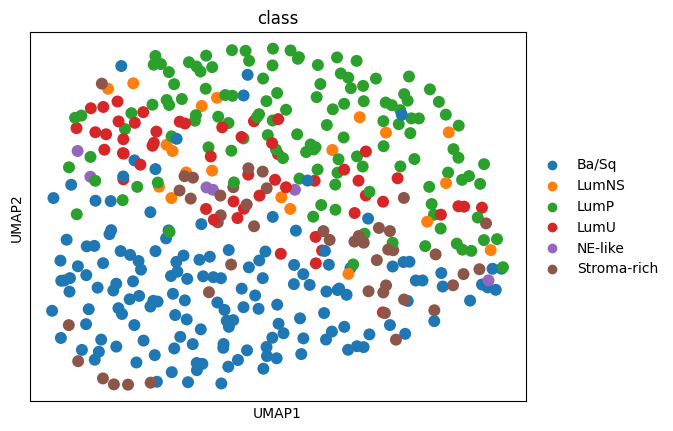

In [ ]:
sc.pp.neighbors(dds, n_neighbors=20, n_pcs=10)
sc.tl.umap(dds, min_dist=0.0)
sc.pl.umap(dds, color = 'class')

##DESeq2 data preprocessing(meth)

**we are going to do the same for methylation data to reduce the genes to significat ones**

In [ ]:
meth

In [ ]:
lables_meth= lables[lables['ID'].isin(meth['ID'])]

In [ ]:
lables_meth

In [ ]:
merged_df1 = pd.merge(lables, meth, on='ID', how='inner')

In [ ]:
methx=merged_df1.drop('class', axis=1)

In [ ]:
methx.set_index('ID', inplace=True)
methx1=methx*1000000
methx1

In [ ]:
column_sums = methx1.sum(axis=0)

# Filter columns based on the sum condition (sum > 0)
selected_columns = column_sums[column_sums > 0].index

# Use the selected_columns to filter the DataFrame
methx_filtered = methx1[selected_columns]

In [ ]:
methx_filtered = methx_filtered.astype(int)
methx_filtered

In [ ]:
import numpy as np
methx_filtered_non_negative = np.maximum(methx_filtered, 0)#remove negative values since DESeq2 doesn't take them
methx_filtered_non_negative

In [ ]:
print(methx_filtered.columns)

In [ ]:
lables_meth.set_index('ID', inplace=True)
lables_meth

##DESeq2(meth)

In [ ]:
dds1 = DeseqDataSet(counts=methx_filtered_non_negative, metadata=lables_meth, design_factors="class")

In [ ]:
dds1.deseq2()

In [ ]:
dds1

In [ ]:
stat_meth_LumP_vs_BaSq = DeseqStats(dds1, contrast = ('class','LumP','Ba/Sq'))
stat_meth_LumP_vs_LumNS = DeseqStats(dds1, contrast = ('class','LumP','LumNS'))
stat_meth_LumP_vs_LumU = DeseqStats(dds1, contrast = ('class','LumP','LumU'))
stat_meth_LumP_vs_NE = DeseqStats(dds1, contrast = ('class','LumP','NE-like'))
stat_meth_LumP_vs_Stroma = DeseqStats(dds1, contrast = ('class','LumP','Stroma-rich'))
stat_meth_LumNS_vs_BaSq = DeseqStats(dds1, contrast = ('class','LumNS','Ba/Sq'))
stat_meth_LumNS_vs_LumU = DeseqStats(dds1, contrast = ('class','LumNS','LumU'))
stat_meth_LumNS_vs_NE = DeseqStats(dds1, contrast = ('class','LumNS','NE-like'))
stat_meth_LumNS_vs_Stroma = DeseqStats(dds1, contrast = ('class','LumNS','Stroma-rich'))
stat_meth_LumU_vs_BaSq = DeseqStats(dds1, contrast = ('class','LumNS','Ba/Sq'))
stat_meth_LumU_vs_NE = DeseqStats(dds1, contrast = ('class','LumNS','NE-like'))
stat_meth_LumU_vs_Stroma = DeseqStats(dds1, contrast = ('class','LumNS','Stroma-rich'))
stat_meth_BaSq_vs_NE = DeseqStats(dds1, contrast = ('class','Ba/Sq','NE-like'))
stat_meth_BaSq_vs_Stroma = DeseqStats(dds1, contrast = ('class','Ba/Sq','Stroma-rich'))
stat_meth_NE_vs_Stroma = DeseqStats(dds1, contrast = ('class','NE-like','Stroma-rich'))

In [ ]:
stat_meth_LumP_vs_BaSq.summary()
stat_meth_LumP_vs_LumNS.summary()
stat_meth_LumP_vs_LumU.summary()
stat_meth_LumP_vs_NE.summary()
stat_meth_LumP_vs_Stroma.summary()
stat_meth_LumNS_vs_BaSq.summary()
stat_meth_LumNS_vs_LumU.summary()
stat_meth_LumNS_vs_NE.summary()
stat_meth_LumNS_vs_Stroma.summary()
stat_meth_LumU_vs_BaSq.summary()
stat_meth_LumU_vs_NE.summary()
stat_meth_LumU_vs_Stroma.summary()
stat_meth_BaSq_vs_NE.summary()
stat_meth_BaSq_vs_Stroma.summary()
stat_meth_NE_vs_Stroma.summary()

In [ ]:
meth_LumP_vs_BaSq=stat_res_LumP_vs_BaSq.results_df
meth_LumP_vs_LumNS = stat_res_LumP_vs_LumNS.results_df
meth_LumP_vs_LumU = stat_res_LumP_vs_LumU.results_df
meth_LumP_vs_NE=stat_res_LumP_vs_NE.results_df
meth_LumP_vs_Stroma=stat_res_LumP_vs_Stroma.results_df
meth_LumNS_vs_BaSq = stat_res_LumNS_vs_BaSq.results_df
meth_LumNS_vs_LumU = stat_res_LumNS_vs_LumU.results_df
meth_LumNS_vs_NE = stat_res_LumNS_vs_NE.results_df
meth_LumNS_vs_Stroma = stat_res_LumNS_vs_Stroma.results_df
meth_LumU_vs_BaSq = stat_res_LumU_vs_BaSq.results_df
meth_LumU_vs_NE = stat_res_LumU_vs_NE.results_df
meth_LumU_vs_Stroma = stat_res_LumU_vs_Stroma.results_df
meth_BaSq_vs_NE = stat_res_BaSq_vs_NE.results_df
meth_BaSq_vs_Stroma = stat_res_BaSq_vs_Stroma.results_df
meth_NE_vs_Stroma = stat_res_NE_vs_Stroma.results_df

In [ ]:
diff_meth_LumP_vs_BaSq = meth_LumP_vs_BaSq[(meth_LumP_vs_BaSq.padj < 0.01) & (abs(meth_LumP_vs_BaSq.log2FoldChange) > 2)]
diff_meth_LumP_vs_LumNS = meth_LumP_vs_LumNS[(meth_LumP_vs_LumNS.padj < 0.01) & (abs(meth_LumP_vs_LumNS.log2FoldChange) > 2)]
diff_meth_LumP_vs_LumU = meth_LumP_vs_BaSq[(meth_LumP_vs_LumU.padj < 0.01) & (abs(meth_LumP_vs_LumU.log2FoldChange) > 2)]
diff_meth_LumP_vs_NE = meth_LumP_vs_BaSq[(meth_LumP_vs_NE.padj < 0.01) & (abs(meth_LumP_vs_NE.log2FoldChange) > 2)]
diff_meth_LumP_vs_Stroma = meth_LumP_vs_Stroma[(meth_LumP_vs_Stroma.padj < 0.01) & (abs(meth_LumP_vs_Stroma.log2FoldChange) > 2)]
diff_meth_LumNS_vs_BaSq = meth_LumNS_vs_BaSq[(meth_LumNS_vs_BaSq.padj < 0.01) & (abs(meth_LumNS_vs_BaSq.log2FoldChange) > 2)]
diff_meth_LumNS_vs_LumU = meth_LumNS_vs_LumU[(meth_LumNS_vs_LumU.padj < 0.01) & (abs(meth_LumNS_vs_LumU.log2FoldChange) > 2)]
diff_meth_LumNS_vs_NE = meth_LumNS_vs_NE[(meth_LumNS_vs_NE.padj < 0.01) & (abs(meth_LumNS_vs_NE.log2FoldChange) > 2)]
diff_meth_LumNS_vs_Stroma = meth_LumNS_vs_Stroma[(meth_LumNS_vs_Stroma.padj < 0.01) & (abs(meth_LumNS_vs_Stroma.log2FoldChange) > 2)]
diff_meth_LumU_vs_BaSq = meth_LumU_vs_BaSq[(meth_LumU_vs_BaSq.padj < 0.01) & (abs(meth_LumU_vs_BaSq.log2FoldChange) > 2)]
diff_meth_LumU_vs_NE = meth_LumU_vs_NE[(meth_LumU_vs_NE.padj < 0.01) & (abs(meth_LumU_vs_NE.log2FoldChange) > 2)]
diff_meth_LumU_vs_Stroma = meth_LumU_vs_Stroma[(meth_LumU_vs_Stroma.padj < 0.01) & (abs(meth_LumU_vs_Stroma.log2FoldChange) > 2)]
diff_meth_BaSq_vs_NE = meth_BaSq_vs_NE[(meth_BaSq_vs_NE.padj < 0.01) & (abs(meth_BaSq_vs_NE.log2FoldChange) > 2)]
diff_meth_BaSq_vs_Stroma = meth_BaSq_vs_Stroma[(meth_BaSq_vs_Stroma.padj < 0.01) & (abs(meth_BaSq_vs_Stroma.log2FoldChange) > 2)]
diff_meth_res_NE_vs_Stroma = meth_NE_vs_Stroma[(meth_NE_vs_Stroma.padj < 0.01) & (abs(meth_NE_vs_Stroma.log2FoldChange) > 2)]

In [ ]:
list_diff_meth_genes = [
    diff_meth_LumP_vs_BaSq,
    diff_meth_LumP_vs_LumNS,
    diff_meth_LumP_vs_LumU,
    diff_meth_LumP_vs_NE,
    diff_meth_LumP_vs_Stroma,
    diff_meth_LumNS_vs_BaSq,
    diff_meth_LumNS_vs_LumU,
    diff_meth_LumNS_vs_NE,
    diff_meth_LumNS_vs_Stroma,
    diff_meth_LumU_vs_BaSq,
    diff_meth_LumU_vs_NE,
    diff_meth_LumU_vs_Stroma,
    diff_meth_BaSq_vs_NE,
    diff_meth_BaSq_vs_Stroma,
    diff_meth_res_NE_vs_Stroma
]

In [ ]:
List_of_meth_genes = np.concatenate([df.index.values for df in list_diff_meth_genes])

List_of_meth_genes = np.unique(List_of_meth_genes)

len(List_of_meth_genes)

In [ ]:
methx

In [ ]:
column_sums = methx.sum(axis=0)
# Filter columns based on the sum condition (e.g., sum > 0)
selected_columns = column_sums[column_sums > 0]

# Use the selected_columns to filter the DataFrame
methx_filtered = methx[selected_columns.index]
methx_filtered.columns

In [ ]:
common_genes = set(methx_filtered.columns).intersection(List_of_meth_genes)
len(common_genes)

In [ ]:
reduced_methx=methx_filtered[common_genes]
reduced_methx

we were able to redice the methilated genes 20109 to 4509

##PCA(meth)

In [ ]:
sc.tl.pca(dds1)
sc.pl.pca(dds1, color = 'class', size = 200)

##Umap (meth)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


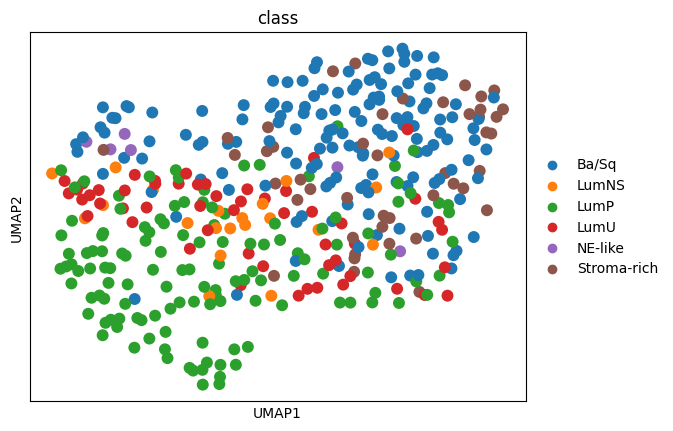

In [ ]:
sc.pp.neighbors(dds1, n_neighbors=20, n_pcs=10)
sc.tl.umap(dds1, min_dist=0.0)
sc.pl.umap(dds1, color = 'class')

# Model initialisation and training part

Here's the section where we download all necessary for the model packages, train the model and measure accuracies

#### Utils

Here we installing all necessary packages for our GAT and visualisation.

In [ ]:
# Install required packages.
#From the tutorial https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=zF5bw3m9UrMy

# Basic packages for neural networks

import os
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# This is needed to create graph dataset
from torch_geometric.data import Data

# GATv2 part
from torch_geometric.nn import GATv2Conv

# We use this metrics to account for class imbalance
from sklearn.metrics import f1_score, precision_score, recall_score

# This is a similarity computaing part
from sklearn.metrics.pairwise import rbf_kernel

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from IPython import display

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Clean df and labels

In [ ]:
clin_df_cleaned = clin_df
retained_ids_by_data = clin_df_cleaned.index
labels_onehot_cleaned = labels_onehot[labels_onehot.index.isin(retained_ids_by_data)]
retained_ids_by_labels = labels_onehot_cleaned.index
clin_df_cleaned = clin_df_cleaned[clin_df_cleaned.index.isin(retained_ids_by_labels)]

## Graph Dataset Prep

### Data preprocessing

In our datasets some patient are missing. But datasets are inconsistent with each other. So one patient can be present in 1 or 2 datasets, but not all. We can't do anything about it, since we need to have labels for all patients.

To solve this issue, we only work with patients which are present in all 4 omics datasets, in labels dataset and in clinical datasets.

In [ ]:
node_data_rna = rna_exp_embedding_no_deseq
node_data_prot = prot_exp_artificial
node_data_mirna = mirna_embedding
node_data_meth = meth_embedding

# First we throw away patients which don't have indexes
node_data_rna = node_data_rna[node_data_rna.index.isin(retained_ids_by_labels)]
node_data_prot = node_data_prot[node_data_prot.index.isin(retained_ids_by_labels)]
node_data_mirna = node_data_mirna[node_data_mirna.index.isin(retained_ids_by_labels)]
node_data_meth = node_data_meth[node_data_meth.index.isin(retained_ids_by_labels)]

# Then we take indexes of remaining patients in all 4 datasets
retained_ids_by_rna_exp = node_data_rna.index
retained_ids_by_prot_exp = node_data_prot.index
retained_ids_by_mirna = node_data_mirna.index
retained_ids_by_meth = node_data_meth.index

# Then for all datasets we throw away all patients which are not present in all 4 of them
node_data_rna = node_data_rna[node_data_rna.index.isin(retained_ids_by_prot_exp)]
node_data_rna = node_data_rna[node_data_rna.index.isin(retained_ids_by_mirna)]
node_data_rna = node_data_rna[node_data_rna.index.isin(retained_ids_by_meth)]

node_data_prot = node_data_prot[node_data_prot.index.isin(retained_ids_by_rna_exp)]
node_data_prot = node_data_prot[node_data_prot.index.isin(retained_ids_by_mirna)]
node_data_prot = node_data_prot[node_data_prot.index.isin(retained_ids_by_meth)]

node_data_mirna = node_data_mirna[node_data_mirna.index.isin(retained_ids_by_rna_exp)]
node_data_mirna = node_data_mirna[node_data_mirna.index.isin(retained_ids_by_prot_exp)]
node_data_mirna = node_data_mirna[node_data_mirna.index.isin(retained_ids_by_meth)]

node_data_meth = node_data_meth[node_data_meth.index.isin(retained_ids_by_rna_exp)]
node_data_meth = node_data_meth[node_data_meth.index.isin(retained_ids_by_prot_exp)]
node_data_meth = node_data_meth[node_data_meth.index.isin(retained_ids_by_mirna)]

# And then finally based on cleaned omics datasets we clean clinical dataset and labels
clin_df_cleaned = clin_df_cleaned[clin_df_cleaned.index.isin(retained_ids_by_rna_exp)]
clin_df_cleaned = clin_df_cleaned[clin_df_cleaned.index.isin(retained_ids_by_prot_exp)]
clin_df_cleaned = clin_df_cleaned[clin_df_cleaned.index.isin(retained_ids_by_mirna)]
clin_df_cleaned = clin_df_cleaned[clin_df_cleaned.index.isin(retained_ids_by_meth)]

labels_onehot_cleaned = labels_onehot_cleaned[labels_onehot_cleaned.index.isin(retained_ids_by_rna_exp)]
labels_onehot_cleaned = labels_onehot_cleaned[labels_onehot_cleaned.index.isin(retained_ids_by_prot_exp)]
labels_onehot_cleaned = labels_onehot_cleaned[labels_onehot_cleaned.index.isin(retained_ids_by_mirna)]
labels_onehot_cleaned = labels_onehot_cleaned[labels_onehot_cleaned.index.isin(retained_ids_by_meth)]

### Similarity indexes

In [ ]:
R = rbf_kernel(clin_df_cleaned, gamma=.5)

# Create a DataFrame for the new dataset
similarity_matrix = []

# Get the patient identifiers
patients = clin_df_cleaned.index.tolist()

# Iterate over rthe matrix to get all pairs
for i in range(len(R)):
    for j in range(len(R)):  # j starts from i+1 to avoid duplicates and self-similarity
    # 2 entries because dataset is undirected
        if (i != j):
          similarity_matrix.append([patients[i], patients[j], R[i][j]])
          similarity_matrix.append([patients[j], patients[i], R[i][j]])

similarity_df = pd.DataFrame(similarity_matrix, columns=['source', 'target', 'rbf_kernel'])

#### Distribution of similarity indexes and cleaning

(array([1.44456e+05, 5.86800e+04, 4.08400e+04, 2.27800e+04, 1.64920e+04,
        6.72000e+03, 1.32560e+04, 4.70800e+03, 1.26400e+03, 1.83200e+03,
        3.39600e+03, 3.76400e+03, 3.60000e+02, 1.44000e+02, 1.52000e+02,
        2.12000e+02, 3.04000e+02, 5.16000e+02, 4.72000e+02, 4.52000e+02]),
 array([2.40958942e-04, 5.02190774e-02, 1.00197196e-01, 1.50175314e-01,
        2.00153433e-01, 2.50131551e-01, 3.00109670e-01, 3.50087788e-01,
        4.00065907e-01, 4.50044025e-01, 5.00022144e-01, 5.50000262e-01,
        5.99978381e-01, 6.49956499e-01, 6.99934618e-01, 7.49912736e-01,
        7.99890855e-01, 8.49868973e-01, 8.99847091e-01, 9.49825210e-01,
        9.99803328e-01]),
 <BarContainer object of 20 artists>)

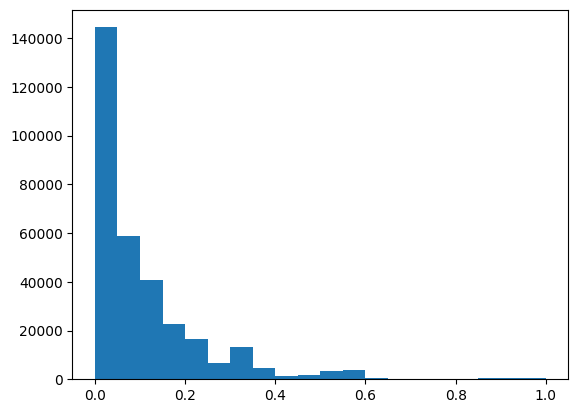

In [ ]:
fig, ax = plt.subplots()
ax.hist(similarity_df['rbf_kernel'], bins=20)

In [ ]:
# And so we keep only highly similar edges:
similarity_df_pruned = similarity_df[similarity_df['rbf_kernel'] >= 0.9]

### Shared part for all graphs

In [ ]:
# Get all unique node names
unique_nodes = pd.concat([similarity_df_pruned['source'], similarity_df_pruned['target']]).unique()

# Create a mapping from node names to integers
# We only can use numbers for the edges in torch
node_mapping = {node: i for i, node in enumerate(unique_nodes)}

similarity_df_pruned['source'] = similarity_df_pruned['source'].map(node_mapping)
similarity_df_pruned['target'] = similarity_df_pruned['target'].map(node_mapping)

# Creating edges
edge_index = similarity_df_pruned[['source', 'target']]
edge_index = torch.tensor(edge_index.values, dtype=torch.int).t().contiguous()

# Add attributes
# Extract similarity scores for edge_attr
edge_attr_data = similarity_df_pruned[['rbf_kernel']]
edge_attr = torch.tensor(edge_attr_data.values, dtype=torch.float)

# number of nodes is simply number of patients
num_nodes = len(clin_df_cleaned)

# train, test split
train_mask = torch.rand(num_nodes) < 0.8  # 89% for training
test_mask = ~(train_mask)  # Remaining for testing

<ipython-input-129-bc9418e65711>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarity_df_pruned['source'] = similarity_df_pruned['source'].map(node_mapping)
<ipython-input-129-bc9418e65711>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarity_df_pruned['target'] = similarity_df_pruned['target'].map(node_mapping)


### Helper functions

In [ ]:
# Creates graph dataset for a given nodes, labels, and edges with attributes (weights) to them
def graph_construction(node_data, labels_onehot, edge_attr, edge_index, name):
    node_features = torch.tensor(node_data.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels_onehot_cleaned.values, dtype=torch.float)

    graph_data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_attr, y=labels_tensor)
    graph_data.edge_index = graph_data.edge_index.type(torch.long)

    graph_data.train_mask = train_mask
    graph_data.test_mask = test_mask

    graph_data.name = name

    return graph_data

# Prints all essential metadata about the graph
def get_graph_metadata(graph_data):
    print(graph_data)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {graph_data.num_nodes}')
    print(f'Number of edges: {graph_data.num_edges}')
    print(f'Average node degree: {graph_data.num_edges / graph_data.num_nodes:.2f}')

    # Check for isolated nodes, self-loops, and undirected graph
    print(f'Has isolated nodes: {graph_data.has_isolated_nodes()}')
    print(f'Has self-loops: {graph_data.has_self_loops()}')
    print(f'Is undirected: {graph_data.is_undirected()}')

### Rna expr Graph Construction

In [ ]:
# Creating graph
graph_data_rna = graph_construction(node_data_rna, labels_onehot_cleaned, edge_attr, edge_index, name="RNA")
get_graph_metadata(graph_data_rna)

Data(x=[401, 24], edge_index=[2, 920], y=[401, 6], edge_weight=[920, 1], train_mask=[401], test_mask=[401], name='RNA')
Number of nodes: 401
Number of edges: 920
Average node degree: 2.29
Has isolated nodes: True
Has self-loops: False
Is undirected: True


### Protein Graph Construction


In [ ]:
# Creating graph
graph_data_prot = graph_construction(node_data_prot, labels_onehot_cleaned, edge_attr, edge_index, name = "PROTEIN")
get_graph_metadata(graph_data_prot)

Data(x=[401, 20], edge_index=[2, 920], y=[401, 6], edge_weight=[920, 1], train_mask=[401], test_mask=[401], name='PROTEIN')
Number of nodes: 401
Number of edges: 920
Average node degree: 2.29
Has isolated nodes: True
Has self-loops: False
Is undirected: True


### miRNA Graph Construction

In [ ]:
# Creating graph
graph_data_mirna = graph_construction(node_data_mirna, labels_onehot_cleaned, edge_attr, edge_index, name = "miRNA")
get_graph_metadata(graph_data_mirna)

Data(x=[401, 10], edge_index=[2, 920], y=[401, 6], edge_weight=[920, 1], train_mask=[401], test_mask=[401], name='miRNA')
Number of nodes: 401
Number of edges: 920
Average node degree: 2.29
Has isolated nodes: True
Has self-loops: False
Is undirected: True


### Meth Graph Construction

In [ ]:
# Creating graph
graph_data_meth = graph_construction(node_data_meth, labels_onehot_cleaned, edge_attr, edge_index, name = "METH")
get_graph_metadata(graph_data_meth)

Data(x=[401, 24], edge_index=[2, 920], y=[401, 6], edge_weight=[920, 1], train_mask=[401], test_mask=[401], name='METH')
Number of nodes: 401
Number of edges: 920
Average node degree: 2.29
Has isolated nodes: True
Has self-loops: False
Is undirected: True


## Model

### GATv2 Head

In [ ]:
class GATv2Net(torch.nn.Module):
    def __init__(self, in_size, hid_size=8, out_size=6, multihead = False, dropout=0.6):
        super(GATv2Net, self).__init__()
        self.conv1 = GATv2Conv(in_size, hid_size, heads=1, concat=False, dropout=dropout, add_self_loops=True, edge_dim=1)
        self.conv2 = GATv2Conv(hid_size, out_size, heads=1, concat=False, dropout=dropout, add_self_loops=True, edge_dim=1)
        self.multihead = multihead

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.elu(self.conv1(x, edge_index, edge_attr=edge_weight))
        x = F.elu(self.conv2(x, edge_index, edge_attr=edge_weight)) if self.multihead else self.conv2(x, edge_index, edge_attr=edge_weight)
        return x

### Dragon

In [ ]:
class MultimodalGAT(torch.nn.Module):
    def __init__(self, num_datasets, in_sizes_list, hid_sizes_list, out_size, mlp_out_features, dropout=0.6):
        super(MultimodalGAT, self).__init__()
        self.gat_heads = torch.nn.ModuleList([GATv2Net(in_sizes_list[i], hid_sizes_list[i], out_size, multihead=True, dropout=dropout) for i in range(num_datasets)])

        # Define the MLP
        self.mlp = torch.nn.Sequential(
            # torch.nn.Linear(num_datasets * out_size, mlp_out_features),
            torch.nn.Linear(num_datasets * out_size, 8),
            torch.nn.ELU(),
            torch.nn.Dropout(),
            torch.nn.Linear(8, mlp_out_features), # Raw logits for CrossEntropyLoss
        )

    def forward(self, data_list):
        # data_list is a list of graph data, one for each GAT head
        concat_output = torch.cat([gat_head(data) for gat_head, data in zip(self.gat_heads, data_list)], dim=1)
        final_output = self.mlp(concat_output)
        return final_output

### Addressing Class Imbalance

In [ ]:
# Calculate weights for each class
class_counts = graph_data_prot.y.sum(axis=0)
total_samples = sum(class_counts)

# + total_samples/70 to reduce dominance of imbalanced classes a bit, because they're becoming too overpridicted
class_weights = [total_samples / (class_count + total_samples/70) for class_count in class_counts]
weights_tensor = torch.tensor(class_weights)

criterion = CrossEntropyLoss(weight=weights_tensor)

### Initialise test labels

In [ ]:
test_true_labels = graph_data_prot.y[graph_data_prot.test_mask].detach().numpy()
test_true_labels_int = np.argmax(test_true_labels, axis=1)

### Helper functions

In [ ]:
# Trains the model
# graph_data could be array of graphs or just a single graph
def train_model(model,
                grap_data,
                optimizer,
                criterion,
                save_model = False):
    # We use this values to keep track of the models with best performance
    # Then we save models which performed best

    best_f1_score = 0
    best_precision_score = 0
    best_recall_score = 0

    train_losses = []
    test_losses = []

    # We don't use early stopping because we want to run through all the epochs in order to fine the best one
    # This is our hand-made hyper parameter optimisation

    for epoch in range(1, 401):
        # Train your model for 'epochs' epochs with early stopping
        model.train()
        optimizer.zero_grad()  # Clear gradients.

        out = model(grap_data)  # Perform a single forward pass.

        # Compute the loss solely based on the training nodes.
        # We use graph_data_prot here only because all datasets share same train and test masks,
        # So it doesn't matter which dataset we use to compute losses, because topologically they are the same
        train_loss = criterion(out[graph_data_prot.train_mask], graph_data_prot.y[graph_data_prot.train_mask].float())


        train_loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        train_losses.append(train_loss.item())


        # Evaluate on validation set
        model.eval()

        output = model(grap_data)
        # print(output.shape, output[graph_data_prot.test_mask].shape, graph_data_prot.y[graph_data_prot.test_mask].shape)
        test_loss = criterion(output[graph_data_prot.test_mask], graph_data_prot.y[graph_data_prot.test_mask].float())
        test_losses.append(test_loss.item())

        probabilities = F.softmax(output, dim=1)

          # Find the index of the max probability for each sample
        _, max_indices = torch.max(probabilities, dim=1)

        # Convert these indices to one-hot encoded format
        predictions = F.one_hot(max_indices, num_classes=probabilities.shape[1])

        test_predictions = predictions[graph_data_prot.test_mask].detach().numpy()
        test_predictions_int = np.argmax(test_predictions, axis=1)

        f1 = f1_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)
        precision = precision_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)
        recall = recall_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)

        # Update best score and epochs
        if f1 > best_f1_score:
            best_f1_score = f1
            best_precision_score = precision
            best_recall_score = recall
            # save the best model, so to load it afterwards
            if save_model:
              torch.save(model.state_dict(), "./best_modal_dict")
        #if precision > best_precision_score:
            #best_precision_score = precision
        #if recall > best_recall_score:
            #best_recall_score = recall

        if epoch % 20 == 0:
          plt.figure(figsize=(10, 6))
          plt.plot(train_losses, label='Train Loss')
          plt.plot(test_losses, label='Test Loss')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          display.clear_output(wait=True)
          display.display(plt.show())
          display.clear_output(wait=True)

    return best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses

In [ ]:
# Trains the model
# graph_data could be array of graphs or just a single graph
def train_model_kfold(model,
                grap_data,
                optimizer,
                criterion,
                save_model = False,
                test_true_labels=test_true_labels,
                test_true_labels_int=test_true_labels_int):
    # We use this values to keep track of the models with best performance
    # Then we save models which performed best

    best_f1_score = 0
    best_precision_score = 0
    best_recall_score = 0

    train_losses = []
    test_losses = []

    # We don't use early stopping because we want to run through all the epochs in order to fine the best one
    # This is our hand-made hyper parameter optimisation

    for epoch in range(1, 201):
        # Train your model for 'epochs' epochs with early stopping
        model.train()
        optimizer.zero_grad()  # Clear gradients.

        out = model(grap_data)  # Perform a single forward pass.

        # Compute the loss solely based on the training nodes.
        # We use graph_data_prot here only because all datasets share same train and test masks,
        # So it doesn't matter which dataset we use to compute losses, because topologically they are the same
        train_loss = criterion(out[graph_data_prot.train_mask], graph_data_prot.y[graph_data_prot.train_mask].float())


        train_loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        train_losses.append(train_loss.item())


        # Evaluate on validation set
        model.eval()

        output = model(grap_data)
        # print(output.shape, output[graph_data_prot.test_mask].shape, graph_data_prot.y[graph_data_prot.test_mask].shape)
        test_loss = criterion(output[graph_data_prot.test_mask], graph_data_prot.y[graph_data_prot.test_mask].float())
        test_losses.append(test_loss.item())

        probabilities = F.softmax(output, dim=1)

          # Find the index of the max probability for each sample
        _, max_indices = torch.max(probabilities, dim=1)

        # Convert these indices to one-hot encoded format
        predictions = F.one_hot(max_indices, num_classes=probabilities.shape[1])

        test_predictions = predictions[graph_data_prot.test_mask].detach().numpy()
        test_predictions_int = np.argmax(test_predictions, axis=1)

        f1 = f1_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)
        precision = precision_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)
        recall = recall_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)

        # Update best score and epochs
        if f1 > best_f1_score:
            best_f1_score = f1
            best_precision_score = precision
            best_recall_score = recall
            # save the best model, so to load it afterwards
            # if save_model:
            #   torch.save(model.state_dict(), "./best_modal_dict")
        #if precision > best_precision_score:
            #best_precision_score = precision
        #if recall > best_recall_score:
            #best_recall_score = recall

        if epoch % 20 == 0:
          print(epoch)

    return best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses

#### Visualisation helper

Pyvis is a Python library that allows you to create interactive network graphs.

In [ ]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_multimodal_gat_model(model, grap_data_list, title_text):
    # Get node and edge information from the graph data for both modalities
    X = [graph_data.x for graph_data in grap_data_list]
    edge_indexes = [graph_data.edge_index for graph_data in grap_data_list]
    edge_weights = [graph_data.edge_weight for graph_data in grap_data_list]
    names = [graph_data.name for graph_data in grap_data_list]

    # Create a Plotly graph
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scattergl'}]])

    for i in range(len(X)):
        print(f"{names[i]}.x dimensions:", X[i].shape)
        print(f"{names[i]}.edge_index dimensions:", edge_indexes[i].shape)


        sources, targets, weights = edge_indexes[i][0].tolist(), edge_indexes[i][1].tolist(), edge_weights[i].tolist()

        for src, dst, weight in zip(sources, targets, weights):
            fig.add_trace(go.Scatter(x=[X[i][src, 0], X[i][dst, 0]], y=[X[i][src, 1], X[i][dst, 1]],
                                 mode='lines',
                                 line=dict(width=1.0),  # Set a constant width
                                 hoverinfo='none',
                                 legendgroup=names[i],
                                 name=f'{names[i]} Edges'))

        # Add nodes for both modalities to the graph with color labels
        fig.add_trace(go.Scatter(x=X[i][:, 0], y=X[i][:, 1],
                                mode='markers',
                                marker=dict(color=i, size=8),
                                hoverinfo='text',
                                text=[f'{names[i]} Node {j}' for j in range(X[i].shape[0])],
                                legendgroup=f'{names[i]}',
                                name=f'{names[i]} Nodes'
                                ))

    # Update layout for better visibility
    fig.update_layout(showlegend=True, height=800, width=800, title_text=title_text)

    # Show the plot
    fig.show()

### Hyperparameter optimisation and training

DONT RUN THIS CODE CELL - IT'LL TAKE FOREVER

isntead use its outputs and run next code cell, since it uses optimised hyper parameters

In [ ]:
# Hyper parameter optimization

best_i = 8
best_k = 8
best_p = 8
best_h = 8

best_lr = 0.001
best_f1_score = 0

for i in range(12, 14):
  for k in range(6, 8):
    for p in range(6, 8):
      for h in range(10, 12):
          for lr in np.linspace(0.01, 0.1, 5):
              model = MultimodalGAT(4,
               [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1], graph_data_mirna.x.shape[1], graph_data_meth.x.shape[1]],
                      [i, k, p, h],
                      out_size=8,
                      mlp_out_features=6)

              optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=5e-4)

              print(f"i: {i}, k: {k}, p: {p}, h: {h}, lr: {lr}")
              result = train_model(model,
                [graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth],
                optimizer,
                criterion,
                True)

              f1 = result[0]
              if f1 > best_f1_score:
                best_i = i
                best_k = k
                best_p = p
                best_h = h
                best_lr = lr
                best_f1_score = f1
                torch.save(model.state_dict(), "./best_modal_dict")

print(f"Best i: {best_i}")
print(f"Best k: {best_k}")
print(f"Best p: {best_p}")
print(f"Best h: {best_h}")
print(f"Best lr: {best_lr}")
print(f"Best f1 score: {best_f1_score}")


KeyboardInterrupt: ignored

In [ ]:
from hyperopt import fmin, tpe, hp
import torch
import numpy as np

# Define the hyperparameter search space
space = {
    'i': hp.quniform('i', 12, 14, 1),
    'k': hp.quniform('k', 6, 8, 1),
    'p': hp.quniform('p', 6, 8, 1),
    'h': hp.quniform('h', 10, 12, 1),
    'lr': hp.uniform('lr', 0.01, 0.1),
}

best_params = {
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'best_f1_score': 0,
}

# Define the objective function
def objective(params):
    model = MultimodalGAT(
        4,
        [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1], graph_data_mirna.x.shape[1], graph_data_meth.x.shape[1]],
        [int(params['i']), int(params['k']), int(params['p']), int(params['h'])],
        out_size=8,
        mlp_out_features=6
    )

    optimizer = torch.optim.Adam(model.parameters(), params['lr'], weight_decay=5e-4)

    print(f"i: {params['i']}, k: {params['k']}, p: {params['p']}, h: {params['h']}, lr: {params['lr']}")
    result = train_model(model,
                         [graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth],
                         optimizer,
                         criterion,
                         True)

    f1 = result[0]
    if f1 > best_params['best_f1_score']:
        best_params.update(params)
        best_params['best_f1_score'] = f1
        torch.save(model.state_dict(), "./best_modal_dict")

    return -f1  # Hyperopt minimizes the objective function

# Perform hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)  # Adjust max_evals as needed

print("Best hyperparameters:", best_params)

100%|██████████| 50/50 [17:05<00:00, 20.52s/trial, best loss: -0.7026077917382265]
Best hyperparameters: {'i': 14.0, 'k': 7.0, 'p': 6.0, 'h': 11.0, 'lr': 0.02092597047483819, 'best_f1_score': 0.7026077917382265}


In [ ]:
from hyperopt import fmin, tpe, hp
import torch
import numpy as np

# Define the hyperparameter search space
space = {
    'i': hp.quniform('i', 13, 17, 1),
    'k': hp.quniform('k', 6, 8, 1),
    'p': hp.quniform('p', 5, 7, 1),
    'h': hp.quniform('h', 10, 12, 1),
    'lr': hp.uniform('lr', 0.01, 0.05),
}

best_params = {
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'best_f1_score': 0,
}

# Define the objective function
def objective(params):
    model = MultimodalGAT(
        4,
        [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1], graph_data_mirna.x.shape[1], graph_data_meth.x.shape[1]],
        [int(params['i']), int(params['k']), int(params['p']), int(params['h'])],
        out_size=8,
        mlp_out_features=6
    )

    optimizer = torch.optim.Adam(model.parameters(), params['lr'], weight_decay=5e-4)

    print(f"i: {params['i']}, k: {params['k']}, p: {params['p']}, h: {params['h']}, lr: {params['lr']}")
    result = train_model(model,
                         [graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth],
                         optimizer,
                         criterion,
                         True)

    f1 = result[0]
    if f1 > best_params['best_f1_score']:
        best_params.update(params)
        best_params['best_f1_score'] = f1
        torch.save(model.state_dict(), "./best_modal_dict")

    return -f1  # Hyperopt minimizes the objective function

# Perform hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)  # Adjust max_evals as needed

print("Best hyperparameters:", best_params)

100%|██████████| 20/20 [07:03<00:00, 21.15s/trial, best loss: -0.7099513455136556]
Best hyperparameters: {'i': 15.0, 'k': 7.0, 'p': 6.0, 'h': 10.0, 'lr': 0.011849443446261843, 'best_f1_score': 0.7099513455136556}


### Cross-Validation

In [ ]:
from hyperopt import fmin, tpe, hp
import torch
import numpy as np

# Define the hyperparameter search space
space = {
    'i': hp.quniform('i', 12, 14, 1),
    'k': hp.quniform('k', 6, 8, 1),
    'p': hp.quniform('p', 6, 8, 1),
    'h': hp.quniform('h', 10, 12, 1),
    'lr': hp.uniform('lr', 0.01, 0.1),
    'dropout': hp.uniform('dropout', 0.3, 0.7),
}

best_params = [{
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'dropout': 0.6,
    'best_f1_score': 0,
}, {
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'dropout': 0.6,
    'best_f1_score': 0,
}, {
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'dropout': 0.6,
    'best_f1_score': 0,
},{
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'dropout': 0.6,
    'best_f1_score': 0,
},{
    'i': 8,
    'k': 8,
    'p': 8,
    'h': 8,
    'lr': 0.001,
    'dropout': 0.6,
    'best_f1_score': 0,
}]

pm = 0
# Define the objective function
def objective(params):
        model = MultimodalGAT(
            4,
            [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1], graph_data_mirna.x.shape[1], graph_data_meth.x.shape[1]],
            [int(params['i']), int(params['k']), int(params['p']), int(params['h'])],
            out_size=8,
            mlp_out_features=6,
            dropout=params['dropout']
        )

        optimizer = torch.optim.Adam(model.parameters(), params['lr'], weight_decay=5e-4)

        print(f"i: {params['i']}, k: {params['k']}, p: {params['p']}, h: {params['h']}, lr: {params['lr']}, dropout: {params['dropout']}")
        result = train_model_kfold(model,
                            [graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth],
                            optimizer,
                            criterion,
                            True,
                            test_true_labels,
                            test_true_labels_int)

        f1 = result[0]
        if f1 > best_params[pm]['best_f1_score']:
            best_params[pm].update(params)
            best_params[pm]['best_f1_score'] = f1
            torch.save(model.state_dict(), "./best_modal_dict")

        return -f1  # Hyperopt minimizes the objective function

# Perform hyperparameter optimization

# K-Fold with 5 folds
k = 5  # Number of folds

indices = np.random.permutation(num_nodes)

for kk in range(k):
    # Calculate indices for test and train for the current fold
    test_start_idx = int(kk * num_nodes / k)
    test_end_idx = num_nodes if kk == k-1 else int((kk + 1) * num_nodes / k)

    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)

    test_mask[indices[test_start_idx:test_end_idx]] = True
    train_mask[~test_mask] = True  # All nodes not in test_mask are in train_mask

    # Create new splits
    graph_data_rna.train_mask = train_mask
    graph_data_rna.test_mask = test_mask

    graph_data_mirna.train_mask = train_mask
    graph_data_mirna.test_mask = test_mask

    graph_data_prot.train_mask = train_mask
    graph_data_prot.test_mask = test_mask

    graph_data_meth.train_mask = train_mask
    graph_data_meth.test_mask = test_mask

    test_true_labels = graph_data_prot.y[graph_data_prot.test_mask].detach().numpy()
    test_true_labels_int = np.argmax(test_true_labels, axis=1)

    pm = kk
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)  # Adjust max_evals as needed

print("Best hyperparameters:", best_params)

i: 13.0, k: 7.0, p: 7.0, h: 11.0, lr: 0.09548479644136665, dropout: 0.5319656470258561
20
40
60
80
100
120
140
160
180
200
i: 13.0, k: 6.0, p: 6.0, h: 11.0, lr: 0.02475982407771133, dropout: 0.6312557944734674
20
40
60
80
100
120
140
160
180
200
i: 12.0, k: 7.0, p: 6.0, h: 10.0, lr: 0.056477333112498806, dropout: 0.49649497016965405
20
40
60
80
100
120
140
160
180
200
i: 12.0, k: 6.0, p: 6.0, h: 11.0, lr: 0.05502950856644494, dropout: 0.6373849702505967
20
40
60
80
100
120
140
160
180
200
i: 14.0, k: 6.0, p: 6.0, h: 11.0, lr: 0.019927977714863036, dropout: 0.5866741882585567
20
40
60
80
100
120
140
160
180
200
i: 13.0, k: 8.0, p: 7.0, h: 11.0, lr: 0.07519475722492105, dropout: 0.39974424570288974
20
40
60
80
100
120
140
160
180
200
i: 13.0, k: 6.0, p: 7.0, h: 10.0, lr: 0.0305448458472646, dropout: 0.6128577787397346
20
40
60
80
100
120
140
160
180
200
i: 12.0, k: 7.0, p: 7.0, h: 10.0, lr: 0.08410355050531619, dropout: 0.34556985310126476
20
40
60
80
100
120
140
160
180
200
i: 12.0, k: 

In [ ]:
best_params

[{'i': 14.0,
  'k': 6.0,
  'p': 6.0,
  'h': 11.0,
  'lr': 0.019927977714863036,
  'dropout': 0.5866741882585567,
  'best_f1_score': 0.7031700680272109},
 {'i': 13.0,
  'k': 7.0,
  'p': 7.0,
  'h': 12.0,
  'lr': 0.03270703739253462,
  'dropout': 0.4190333044913677,
  'best_f1_score': 0.7031319517620889},
 {'i': 13.0,
  'k': 8.0,
  'p': 8.0,
  'h': 11.0,
  'lr': 0.02130997323707364,
  'dropout': 0.3146213585587884,
  'best_f1_score': 0.7660739805535827},
 {'i': 14.0,
  'k': 7.0,
  'p': 7.0,
  'h': 11.0,
  'lr': 0.010056561934363589,
  'dropout': 0.3089072499968312,
  'best_f1_score': 0.736263876040703},
 {'i': 13.0,
  'k': 7.0,
  'p': 7.0,
  'h': 11.0,
  'lr': 0.01482871036359713,
  'dropout': 0.3169466938394866,
  'best_f1_score': 0.6807130259511212}]

### Best averaged F1 score from cross-validation

In [ ]:
best_average_f1 = sum(f1['best_f1_score'] for f1 in best_params) / k

In [ ]:
print(best_average_f1)

0.7178705804669413


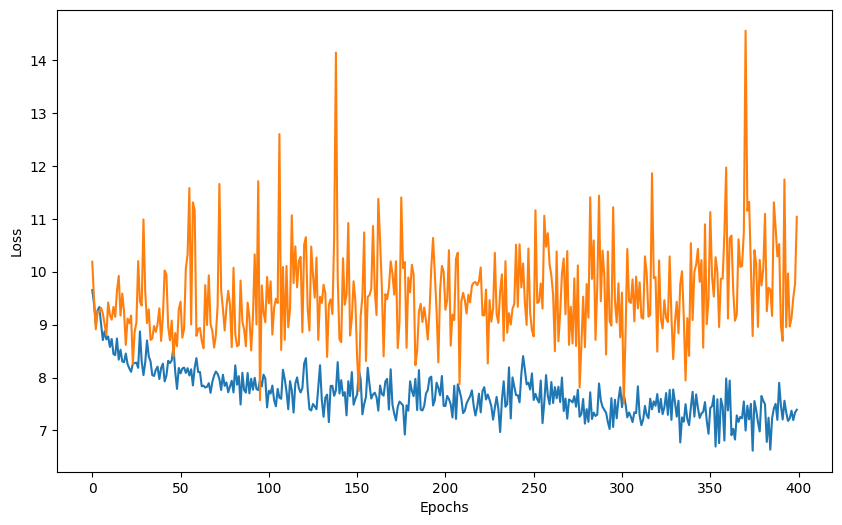

None

In [ ]:
# Training model with optimised hyper parameters

model = MultimodalGAT(4,
               [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1], graph_data_mirna.x.shape[1], graph_data_meth.x.shape[1]],
               [14, 6, 7, 12],
                out_size=8,
                mlp_out_features=6)

optimizer = torch.optim.Adam(model.parameters(), 0.013416741457545985, weight_decay=5e-4)

result = train_model(model,
 [graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth],
                     optimizer,
                     criterion,
                     True)

### Accuracy

#### Preparation of outputs

In [ ]:
# load the best model
model.load_state_dict(torch.load("./best_modal_dict"))
model.eval()
output = model([graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth])
probabilities = F.softmax(output, dim=1)

# Find the index of the max probability for each sample
_, max_indices = torch.max(probabilities, dim=1)

# Convert these indices to one-hot encoded format
predictions = F.one_hot(max_indices, num_classes=probabilities.shape[1])

test_predictions = predictions[graph_data_rna.test_mask]
test_predictions_int = np.argmax(test_predictions, axis=1)

#### Distribution of classes in final prediction

<Axes: >

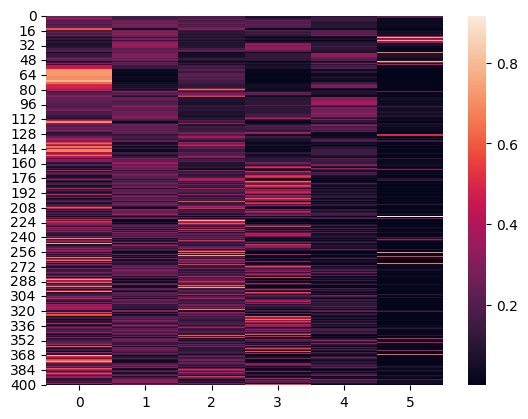

In [ ]:
sns.heatmap(probabilities.detach().numpy())

  #### F1 score

In [ ]:
f1 = f1_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)
precision = precision_score(test_true_labels_int, test_predictions_int, average='weighted',zero_division=1)
recall = recall_score(test_true_labels_int, test_predictions_int, average='weighted',zero_division=1)

print("Best f1 score:", f1)
print("Precision score:", precision)
print("Recall score:", recall)

Best f1 score: 0.7156175685810944
Precision score: 0.7683330183330184
Recall score: 0.7027027027027027


**Results on 80% train instead of 89%**:

In [ ]:
f1 = f1_score(test_true_labels_int, test_predictions_int, average='weighted', zero_division=1)
precision = precision_score(test_true_labels_int, test_predictions_int, average='weighted',zero_division=1)
recall = recall_score(test_true_labels_int, test_predictions_int, average='weighted',zero_division=1)

print("Best f1 score:", f1)
print("Precision score:", precision)
print("Recall score:", recall)

In [ ]:
for class_idx in range(graph_data_prot.y.shape[1]):
    unique_values = np.unique(graph_data_prot.y[:, class_idx])
    print(f"Class {class_idx} unique values:", unique_values)

  ### Network Visualization

In [ ]:
visualize_multimodal_gat_model(model,
                               [graph_data_rna, graph_data_prot, graph_data_mirna, graph_data_meth],
                               title_text="GATv2 Network Visualization")

  #### Interactive Network Visualization

In [ ]:
# We don't call this function anywhere in our code
# I don't think we need to keep it (emil)

def visualize_gatv2_model(model, data, output_file="gatv2_visualization_prot.html"):
    print("Data.x dimensions:", data.x.shape)
    print("Data.edge_index dimensions:", data.edge_index.shape)

    # Set up the pyvis network
    gat_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    gat_net.barnes_hut()

    # Get node and edge information from the graph data
    x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

    if edge_index.dim() == 1:  # Handling 0-dimensional edge_index
        edge_index = edge_index.unsqueeze(0)

    sources, targets, weights = edge_index[0].tolist(), edge_index[1].tolist(), edge_weight.tolist()

    # Add nodes and edges to the network
    for src, dst, weight in zip(sources, targets, weights):
        gat_net.add_node(src, src, title=f"Node {src}")
        gat_net.add_node(dst, dst, title=f"Node {dst}")
        gat_net.add_edge(src, dst, value=weight)

    # Get neighbor information for each node
    neighbor_map = {node_id: [str(neighbor.item()) for neighbor in data.edge_index[1, data.edge_index[0] == node_id]] for node_id in range(data.x.size(0))}

    # Add neighbor data to node hover data
    for node_id, neighbors in neighbor_map.items():
        if node_id in gat_net.node_map:  # Check if the node exists in the network
            node_title = gat_net.get_node(node_id)["title"]
            gat_net.add_node(node_id, title=f"{node_title}<br>Neighbors:<br>{'<br>'.join(neighbors)}")
            gat_net.add_edge(node_id, node_id)  # Self-loop to visualize node

    # Save the visualization to an HTML file
    output_file = "gatv2_visualization_prot.html"
    gat_net.show_buttons(filter_=['physics'])
    gat_net.save_graph(output_file)

    # Different options to visualize the output depending of the environment (VSCode, GoogleColab, ...)

    # Open the HTML file in a new tab or browser
    import webbrowser
    webbrowser.open('file://' + os.path.realpath(output_file))

    # Open the HTML file in a new tab or browser
    from IPython.display import HTML
    HTML(filename=output_file)

    # List files in the current working directory
    !ls
    # Download the HTML file
    from google.colab import files
    files.download("gatv2_visualization_prot.html")


# Comparing modalities

In [ ]:
modality_results = []

### Protein

In [ ]:
# Initialize the model
model = GATv2Net(in_size=graph_data_prot.x.shape[1], hid_size=12, out_size=6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses = train_model(model,
            graph_data_prot,
            optimizer,
            criterion)

In [ ]:
print("Best precision, recall, f1 scores:", )
print(best_precision_score, best_recall_score, best_f1_score, sep='\t')

In [ ]:
modality_results.append({'precision':best_precision_score,'recall':best_recall_score,'f1-score':best_f1_score})
modality_results

In [ ]:
print("Best precision score:", best_precision_score)
print("Best f1 score:", best_f1_score)
print("Best recall score:", best_recall_score)

In [ ]:
# Plot the loss over time
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs for Protein dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  #### Network Visualization

In [ ]:
visualize_multimodal_gat_model(model, [graph_data_prot], title_text="GATv2 Network Visualization for Protein Dataset")

### Gene exp

In [ ]:
# Initialize the model
model = GATv2Net(in_size=graph_data_rna.x.shape[1], hid_size=13, out_size=6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses = train_model(model,
            graph_data_rna,
            optimizer,
            criterion)

In [ ]:
print("Best precision score:", best_precision_score)
print("Best f1 score:", best_f1_score)
print("Best recall score:", best_recall_score)

modality_results.append({'precision':best_precision_score,'recall':best_recall_score,'f1-score':best_f1_score})

In [ ]:
# Plot the loss over time
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs for Gene Expression dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  #### Network Visualization

In [ ]:
visualize_multimodal_gat_model(model, [graph_data_rna], title_text="GATv2 Network Visualization for RNA Dataset")

### miRNA

In [ ]:
# Initialize the model
model = GATv2Net(in_size=graph_data_mirna.x.shape[1], hid_size=13, out_size=6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses = train_model(model,
            graph_data_mirna,
            optimizer,
            criterion)

In [ ]:
print("Best precision score:", best_precision_score)
print("Best f1 score:", best_f1_score)
print("Best recall score:", best_recall_score)

modality_results.append({'precision':best_precision_score,'recall':best_recall_score,'f1-score':best_f1_score})

In [ ]:
# Plot the loss over time
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs for RNA dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  #### Network Visualization

In [ ]:
visualize_multimodal_gat_model(model, [graph_data_mirna], title_text="GATv2 Network Visualization for miRNA Dataset")

### Meth

In [ ]:
# Initialize the model
model = GATv2Net(in_size=graph_data_meth.x.shape[1], hid_size=13, out_size=6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses = train_model(model,
            graph_data_meth,
            optimizer,
            criterion)

In [ ]:
print("Best precision score:", best_precision_score)
print("Best f1 score:", best_f1_score)
print("Best recall score:", best_recall_score)

modality_results.append({'precision':best_precision_score,'recall':best_recall_score,'f1-score':best_f1_score})

In [ ]:
# Plot the loss over time
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs for DNA methylation dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  #### Network Visualization

In [ ]:
visualize_multimodal_gat_model(model, [graph_data_meth], title_text="GATv2 Network Visualization for Meth Dataset")

### Protein + Gene exp

In [ ]:
# Initialize the model
model = MultimodalGAT(2, [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1]], [13, 11], out_size=8, mlp_out_features=6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses = train_model(model,
            [graph_data_rna, graph_data_prot],
            optimizer,
            criterion)

In [ ]:
print("Best precision score:", best_precision_score)
print("Best f1 score:", best_f1_score)
print("Best recall score:", best_recall_score)

modality_results.append({'precision':best_precision_score,'recall':best_recall_score,'f1-score':best_f1_score})

In [ ]:
# Plot the loss over time
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs for Protein and Gene Expression dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  #### Network Visualization

In [ ]:
# Call the visualization function after your training loop
visualize_multimodal_gat_model(model, [graph_data_rna, graph_data_prot], title_text="Multimodal GAT Network Visualization for RNA and Protein Dataset")


### Protein + Gene exp + miRNA

In [ ]:
# Initialize the model
model = MultimodalGAT(3, [graph_data_rna.x.shape[1], graph_data_prot.x.shape[1], graph_data_mirna.x.shape[1]], [13, 11, 8], out_size=8, mlp_out_features=6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

best_f1_score, best_recall_score, best_precision_score, train_losses, test_losses = train_model(model,
            [graph_data_rna, graph_data_prot, graph_data_mirna],
            optimizer,
            criterion)

In [ ]:
print("Best precision score:", best_precision_score)
print("Best f1 score:", best_f1_score)
print("Best recall score:", best_recall_score)

modality_results.append({'precision':best_precision_score,'recall':best_recall_score,'f1-score':best_f1_score})

In [ ]:
# Plot the loss over time
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs for Protein, Gene Expression and RNA dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  #### ROC Curve

  #### Network Visualization

In [ ]:
# Call the visualization function after your training loop
visualize_multimodal_gat_model(model, [graph_data_rna, graph_data_prot, graph_data_mirna], title_text="Multimodal GAT Network Visualization for RNA, Protein, and miRNA Dataset")

### Results Integradion

In [ ]:
modality_results

In [ ]:
results_df = pd.DataFrame(modality_results)
results_df.columns = ['Precision','Recall','F1-score']
results_df

In [ ]:
results_df.round(2)